In [1]:
# load required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import datetime
%matplotlib inline

from skimage.measure import compare_ssim
from sklearn.model_selection import train_test_split

# load required functionality from keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, AveragePooling2D
from keras.models import Model
from keras.layers import Lambda
from keras.layers import Input
from keras.layers import UpSampling2D, LeakyReLU
from keras.layers import concatenate
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Add, Subtract
from keras.callbacks import ModelCheckpoint, EarlyStopping, History 
from keras.optimizers import RMSprop, Adadelta, Adam
from keras.utils import np_utils
from keras import backend as keras_backend


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
keras_backend.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1471225372122611097
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6602251960
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8702233695734232873
physical_device_desc: "device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:06:00.0, compute capability: 7.5"
]


['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
"""
    Peak Signal-to-Noise Ratio:
         > 40dB: great
        30~40dB: good
        20~30dB: bad
         < 20dB: worse
"""
def PSNR(y_true, y_pred):
    return -10. * np.log10(np.mean(np.square(y_pred - y_true)))

def SSIM(img1, img2, _range=None, multichannel=False):
    return compare_ssim(img1, img2, data_range=_range, multichannel=multichannel)

def printHistory(history): 
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss 
    plt.plot(history.history['loss']) 
    plt.plot(history.history['val_loss']) 
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
import scipy
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

class DataLoader():
    def __init__(self, dataset_name, img_res=(512, 512)):
        self.dataset_name = dataset_name
        self.img_res = img_res

    def load_data(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "test"
        
        path = glob('./datasets/%s/*' % (self.dataset_name))

        batch_images = np.random.choice(path, size=batch_size)

        imgs_hr = []
        imgs_lr = []
        for img_path in batch_images:
            img = self.imread(img_path)

            h, w = self.img_res
            low_h, low_w = int(h / 4), int(w / 4)

            img_hr = scipy.misc.imresize(img, self.img_res)
            img_lr = scipy.misc.imresize(img, (low_h, low_w))

            # If training => do random flip
            if not is_testing and np.random.random() < 0.5:
                img_hr = np.fliplr(img_hr)
                img_lr = np.fliplr(img_lr)

            imgs_hr.append(img_hr)
            imgs_lr.append(img_lr)

        imgs_hr = np.array(imgs_hr) / 127.5 - 1.
        imgs_lr = np.array(imgs_lr) / 127.5 - 1.

        return imgs_hr, imgs_lr


    def imread(self, path):
        return scipy.misc.imread(path, mode='RGB').astype(np.float)

In [12]:
"""
    GAN model
    
    https://github.com/daymos/simple_keras_GAN/blob/master/gan.py
    https://github.com/MathiasGruber/SRGAN-Keras
"""
class GAN(object):
    """ Generative Adversarial Network class """
    def __init__(self, width=512, height=512, channels=1, batch=8):

        self.width = width
        self.height = height
        self.channels = channels
        self.batch = batch

        self.shape = (self.width, self.height, self.channels)

        self.optimizer = Adam(0.0002, 0.5)

        self.G = self.__generator()
        self.G.compile(loss='mean_squared_error', optimizer=self.optimizer)
        #self.G.load_weights("SRCNN_afterGAUSS_0492.h5")

        self.D = self.__discriminator()
        self.D.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])

        self.stacked_generator_discriminator = self.__stacked_generator_discriminator()
        self.stacked_generator_discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizer)
    
    def save_weights(self, epoch):
        """Save the generator and discriminator networks"""
        self.G.save_weights("gan/_generator_{}.h5".format(epoch))
        self.D.save_weights("gan/_discriminator_{}.h5".format(epoch))

    def load_weights(self, generator_weights=None, discriminator_weights=None, **kwargs):
        if generator_weights:
            self.G.load_weights(generator_weights, **kwargs)
        if discriminator_weights:
            self.D.load_weights(discriminator_weights, **kwargs)
        
    def __generator(self):
        """ Declare generator """

        model = Sequential()
        model.add(Conv2D(64, (3, 3), activation='relu',input_shape=self.shape ,padding="same"))
        model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
        model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
        model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
        model.add(Conv2D(1, (3, 3), activation='relu', padding="same"))

        return model

    def __discriminator(self, filters=32):
        """ 
        Declare discriminator 
        """
        def conv2d_block(input, filters, strides=1, bn=True):
            d = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d
        
        # Input high resolution image
        img = Input(shape=self.shape)
        x = conv2d_block(img, filters, bn=False)
        x = conv2d_block(x, filters, strides=2)
        x = conv2d_block(x, filters*2)
        x = conv2d_block(x, filters*2, strides=2)
        x = conv2d_block(x, filters*4)
        x = conv2d_block(x, filters*4, strides=2)
        x = conv2d_block(x, filters*8)
        x = conv2d_block(x, filters*8, strides=2)
        x = Flatten()(x)
        x = Dense(filters*16)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dense(1 , activation='softmax')(x)

        # Create model and compile
        model = Model(inputs=img, outputs=x)
        print(model.summary())
        return model

    def __stacked_generator_discriminator(self):
        """Create the combined GAN network"""

        # In the combined model we only train the generator
        self.D.trainable = False

        model = Sequential()
        model.add(self.G)
        model.add(self.D)

        return model

    def train(self, X_train, Y_train, epochs=20000, batch = 8):
        
        # Each epoch == "update iteration" as defined in the paper        
        #print_losses = {"G": [], "D": []}
        start_time = datetime.datetime.now()
        
        for cnt in range(epochs):

            ## train discriminator
            random_index = np.random.choice(len(Y_train), np.int64(batch/2))
            legit_images = Y_train[random_index]
            
            random_index = np.random.choice(len(X_train), np.int64(batch/2))
            noise_images = X_train[random_index]
            synthetic_images = self.G.predict(noise_images)

            x_combined_batch = np.concatenate((legit_images, synthetic_images))
            y_combined_batch = np.concatenate((np.ones((np.int64(batch/2), 1)), np.zeros((np.int64(batch/2), 1))))

            d_loss = self.D.train_on_batch(x_combined_batch, y_combined_batch)

            """
            real_loss = self.discriminator.train_on_batch(imgs_hr, real)
            fake_loss = self.discriminator.train_on_batch(generated_hr, fake)
            discriminator_loss = 0.5 * np.add(real_loss, fake_loss)
            """
            
            ## train generator
            random_index = np.random.choice(len(X_train), np.int64(batch))
            noise_images = X_train[random_index]
            # The generators want the discriminators to label the generated images as real
            y_mislabled = np.ones((batch, 1))
            
            #combined
            g_loss = self.stacked_generator_discriminator.train_on_batch(noise_images, y_mislabled)

            print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss[0], g_loss))
            
            
            elapsed_time = datetime.datetime.now() - start_time
            # Plot the progress
            print ("%d time: %s" % (cnt, elapsed_time))
            if cnt % 100 == 0:
                self.save_weights(cnt+1)
            
            

"""
if __name__ == '__main__':
    
    ## FIRST STAGE: TRAINING GENERATOR ONLY WITH MSE LOSS
    ######################################################
        
    #done in previous training
    
    
    ## SECOND STAGE: TRAINING GAN WITH HIGH LEARNING RATE
    ######################################################

    gan = GAN()
    gan.train(X_train)
    
    ## THIRD STAGE: FINE TUNE GAN WITH LOW LEARNING RATE
    ######################################################

    gan = GAN()
    gan.train(X_train)
"""


"\nif __name__ == '__main__':\n    \n    ## FIRST STAGE: TRAINING GENERATOR ONLY WITH MSE LOSS\n    ######################################################\n        \n    #done in previous training\n    \n    \n    ## SECOND STAGE: TRAINING GAN WITH HIGH LEARNING RATE\n    ######################################################\n\n    gan = GAN()\n    gan.train(X_train)\n    \n    ## THIRD STAGE: FINE TUNE GAN WITH LOW LEARNING RATE\n    ######################################################\n\n    gan = GAN()\n    gan.train(X_train)\n"

In [3]:
"""
    load training data
"""
import gc

dataY = np.zeros((4000,512, 512))

count = 0
for i in range(1, 801):
    picture = f'{i:#04d}'
    img = cv2.imread("../../div2k_train_gray/" + picture + ".png", cv2.IMREAD_GRAYSCALE)
    dataY[count] = img
    dataY[count+1] = img
    dataY[count+2] = img
    dataY[count+3] = img
    dataY[count+4] = img
    count += 5
                 
dataY = dataY.reshape(-1, 512, 512, 1)
dataY = dataY.astype('float32') / 255

In [4]:
"""
    noise image
"""
X = np.zeros((4000,512, 512))
count = 0
for i in range(1, 801):
    picture = f'{i:#04d}'
    img = cv2.imread("../../div2k_train_gray/" + picture + "_noise50.png", cv2.IMREAD_GRAYSCALE)
    X[count] = img
    img = cv2.imread("../../div2k_train_gray/" + picture + "_noise60.png", cv2.IMREAD_GRAYSCALE)
    X[count+1] = img
    img = cv2.imread("../../div2k_train_gray/" + picture + "_noise70.png", cv2.IMREAD_GRAYSCALE)
    X[count+2] = img
    img = cv2.imread("../../div2k_train_gray/" + picture + "_noise80.png", cv2.IMREAD_GRAYSCALE)
    X[count+3] = img
    img = cv2.imread("../../div2k_train_gray/" + picture + "_noise90.png", cv2.IMREAD_GRAYSCALE)
    X[count+4] = img
    count += 5

X = X.reshape(-1, 512, 512, 1)
X = X.astype('float32') / 255
                 
X_train, X_test, y_train, y_test = train_test_split(X, dataY, test_size=0.3, random_state=41)

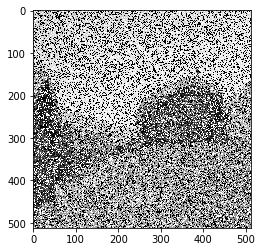

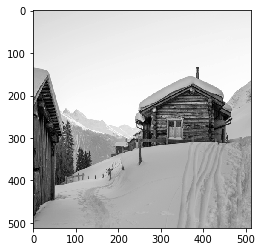

7.874676585197449


In [23]:
X_train = X_train.reshape(-1, 512, 512)
y_train = y_train.reshape(-1, 512, 512)
img = X_train[1]
plt.imshow(img, cmap="gray")
plt.show()
img = y_train[1]
plt.imshow(img, cmap="gray")
plt.show()
print(PSNR(y_train[1], X_train[1]) )
X_train = X_train.reshape(-1, 512, 512, 1)
y_train = y_train.reshape(-1, 512, 512, 1)

In [11]:








"""
    test Discriminator
"""
def Discriminator(filters=16):

    def conv2d_block(input, filters, strides=1, bn=True):
        d = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(input)
        d = LeakyReLU(alpha=0.2)(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        return d
        
    # Input high resolution image
    img = Input(shape=(512, 512, 1))
    x = conv2d_block(img, filters, bn=False)
    x = conv2d_block(x, filters, strides=2)
    x = conv2d_block(x, filters*2)
    x = conv2d_block(x, filters*2, strides=2)
    x = conv2d_block(x, filters*4)
    x = conv2d_block(x, filters*4, strides=2)
    x = conv2d_block(x, filters*8)
    x = conv2d_block(x, filters*8, strides=2)
    x = Flatten()(x)
    x = Dense(filters*16)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1 , activation='softmax')(x)

    # Create model and compile
    model = Model(inputs=img, outputs=x)
    print(model.summary())
    return model

testModel = Discriminator()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 512, 512, 1)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 512, 512, 16)      160       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512, 512, 16)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 256, 256, 16)      2320      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256, 256, 16)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 16)      64        
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 256, 256, 32)      4640      
__________

(4000, 512, 512, 1)


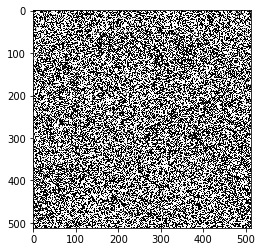

[0.]
[1.]
Train on 2800 samples, validate on 1200 samples
Epoch 1/10
2800/2800 [==============================] - 92s 33ms/step - loss: 11.3874 - acc: 0.2857 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2/10
2800/2800 [==============================] - 88s 32ms/step - loss: 11.3874 - acc: 0.2857 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3/10
2800/2800 [==============================] - 89s 32ms/step - loss: 11.3874 - acc: 0.2857 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4/10
2800/2800 [==============================] - 88s 32ms/step - loss: 11.3874 - acc: 0.2857 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 5/10
2800/2800 [==============================] - 88s 32ms/step - loss: 11.3874 - acc: 0.2857 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 6/10
2800/2800 [==============================] - 89s 32ms/step - loss: 11.3874 - acc: 0.2857 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 7/10
2800/2800 [==============================] - 91s 33ms/step - loss: 11.3874 - acc: 0.2

In [12]:
_X_train = np.concatenate((X_train[:2000], y_train[:2000]))
_y_train = np.concatenate((np.zeros((2000, 1)), np.ones((2000, 1))))

print(_X_train.shape)
img = _X_train[10]
img = img.reshape(512, 512)
plt.imshow(img, cmap="gray")
plt.show()
print(_y_train[10])
print(_y_train[2010])

mC = ModelCheckpoint('test_Discriminator_{epoch:04d}.h5', save_weights_only=True, save_best_only=True)
#keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
earlyStop = EarlyStopping(monitor='val_loss', patience=20)
history = History()
testModel.compile(loss="binary_crossentropy",
                  optimizer=Adam(),
                  metrics=['accuracy'])

testModel.fit(_X_train, _y_train,
          batch_size=1,
          epochs=10,
          verbose=1,
          validation_split=0.3,
          callbacks=[mC, history])







In [10]:
result = testModel.predict(X_train)
print(len(result))
for i in range( len(result) ):
    print(i)
    print(result[i])

2800
0
[1.]
1
[1.]
2
[1.]
3
[1.]
4
[1.]
5
[1.]
6
[1.]
7
[1.]
8
[1.]
9
[1.]
10
[1.]
11
[1.]
12
[1.]
13
[1.]
14
[1.]
15
[1.]
16
[1.]
17
[1.]
18
[1.]
19
[1.]
20
[1.]
21
[1.]
22
[1.]
23
[1.]
24
[1.]
25
[1.]
26
[1.]
27
[1.]
28
[1.]
29
[1.]
30
[1.]
31
[1.]
32
[1.]
33
[1.]
34
[1.]
35
[1.]
36
[1.]
37
[1.]
38
[1.]
39
[1.]
40
[1.]
41
[1.]
42
[1.]
43
[1.]
44
[1.]
45
[1.]
46
[1.]
47
[1.]
48
[1.]
49
[1.]
50
[1.]
51
[1.]
52
[1.]
53
[1.]
54
[1.]
55
[1.]
56
[1.]
57
[1.]
58
[1.]
59
[1.]
60
[1.]
61
[1.]
62
[1.]
63
[1.]
64
[1.]
65
[1.]
66
[1.]
67
[1.]
68
[1.]
69
[1.]
70
[1.]
71
[1.]
72
[1.]
73
[1.]
74
[1.]
75
[1.]
76
[1.]
77
[1.]
78
[1.]
79
[1.]
80
[1.]
81
[1.]
82
[1.]
83
[1.]
84
[1.]
85
[1.]
86
[1.]
87
[1.]
88
[1.]
89
[1.]
90
[1.]
91
[1.]
92
[1.]
93
[1.]
94
[1.]
95
[1.]
96
[1.]
97
[1.]
98
[1.]
99
[1.]
100
[1.]
101
[1.]
102
[1.]
103
[1.]
104
[1.]
105
[1.]
106
[1.]
107
[1.]
108
[1.]
109
[1.]
110
[1.]
111
[1.]
112
[1.]
113
[1.]
114
[1.]
115
[1.]
116
[1.]
117
[1.]
118
[1.]
119
[1.]
120
[1.]
121
[1.]
122
[1.

[1.]
1303
[1.]
1304
[1.]
1305
[1.]
1306
[1.]
1307
[1.]
1308
[1.]
1309
[1.]
1310
[1.]
1311
[1.]
1312
[1.]
1313
[1.]
1314
[1.]
1315
[1.]
1316
[1.]
1317
[1.]
1318
[1.]
1319
[1.]
1320
[1.]
1321
[1.]
1322
[1.]
1323
[1.]
1324
[1.]
1325
[1.]
1326
[1.]
1327
[1.]
1328
[1.]
1329
[1.]
1330
[1.]
1331
[1.]
1332
[1.]
1333
[1.]
1334
[1.]
1335
[1.]
1336
[1.]
1337
[1.]
1338
[1.]
1339
[1.]
1340
[1.]
1341
[1.]
1342
[1.]
1343
[1.]
1344
[1.]
1345
[1.]
1346
[1.]
1347
[1.]
1348
[1.]
1349
[1.]
1350
[1.]
1351
[1.]
1352
[1.]
1353
[1.]
1354
[1.]
1355
[1.]
1356
[1.]
1357
[1.]
1358
[1.]
1359
[1.]
1360
[1.]
1361
[1.]
1362
[1.]
1363
[1.]
1364
[1.]
1365
[1.]
1366
[1.]
1367
[1.]
1368
[1.]
1369
[1.]
1370
[1.]
1371
[1.]
1372
[1.]
1373
[1.]
1374
[1.]
1375
[1.]
1376
[1.]
1377
[1.]
1378
[1.]
1379
[1.]
1380
[1.]
1381
[1.]
1382
[1.]
1383
[1.]
1384
[1.]
1385
[1.]
1386
[1.]
1387
[1.]
1388
[1.]
1389
[1.]
1390
[1.]
1391
[1.]
1392
[1.]
1393
[1.]
1394
[1.]
1395
[1.]
1396
[1.]
1397
[1.]
1398
[1.]
1399
[1.]
1400
[1.]
1401
[1.]
1402


[1.]
2560
[1.]
2561
[1.]
2562
[1.]
2563
[1.]
2564
[1.]
2565
[1.]
2566
[1.]
2567
[1.]
2568
[1.]
2569
[1.]
2570
[1.]
2571
[1.]
2572
[1.]
2573
[1.]
2574
[1.]
2575
[1.]
2576
[1.]
2577
[1.]
2578
[1.]
2579
[1.]
2580
[1.]
2581
[1.]
2582
[1.]
2583
[1.]
2584
[1.]
2585
[1.]
2586
[1.]
2587
[1.]
2588
[1.]
2589
[1.]
2590
[1.]
2591
[1.]
2592
[1.]
2593
[1.]
2594
[1.]
2595
[1.]
2596
[1.]
2597
[1.]
2598
[1.]
2599
[1.]
2600
[1.]
2601
[1.]
2602
[1.]
2603
[1.]
2604
[1.]
2605
[1.]
2606
[1.]
2607
[1.]
2608
[1.]
2609
[1.]
2610
[1.]
2611
[1.]
2612
[1.]
2613
[1.]
2614
[1.]
2615
[1.]
2616
[1.]
2617
[1.]
2618
[1.]
2619
[1.]
2620
[1.]
2621
[1.]
2622
[1.]
2623
[1.]
2624
[1.]
2625
[1.]
2626
[1.]
2627
[1.]
2628
[1.]
2629
[1.]
2630
[1.]
2631
[1.]
2632
[1.]
2633
[1.]
2634
[1.]
2635
[1.]
2636
[1.]
2637
[1.]
2638
[1.]
2639
[1.]
2640
[1.]
2641
[1.]
2642
[1.]
2643
[1.]
2644
[1.]
2645
[1.]
2646
[1.]
2647
[1.]
2648
[1.]
2649
[1.]
2650
[1.]
2651
[1.]
2652
[1.]
2653
[1.]
2654
[1.]
2655
[1.]
2656
[1.]
2657
[1.]
2658
[1.]
2659


In [11]:
## FIRST STAGE: TRAINING GENERATOR ONLY WITH MSE LOSS
######################################################
  
#done in previous training


## SECOND STAGE: TRAINING GAN WITH HIGH LEARNING RATE
######################################################

gan = GAN()
gan.train(X_train, y_train, epochs=20000)


"""
## THIRD STAGE: FINE TUNE GAN WITH LOW LEARNING RATE
######################################################

gan = GAN()
gan.train(X_train)
"""

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 512, 512, 1)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 512, 512, 16)      160       
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 512, 512, 16)      0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 256, 256, 16)      2320      
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 256, 256, 16)      0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 256, 256, 16)      64        
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 256, 256, 32)      4640      
__________

C:\Users\tomsan\Miniconda3\envs\testJ\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
0 time: 0:00:10.791744
epoch: 1, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1 time: 0:00:13.318546
epoch: 2, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2 time: 0:00:13.787652
epoch: 3, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3 time: 0:00:14.262760
epoch: 4, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4 time: 0:00:14.691856
epoch: 5, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5 time: 0:00:15.119953
epoch: 6, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6 time: 0:00:15.577056
epoch: 7, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7 time: 0:00:16.046162
epoch: 8, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8 time: 0:00:16.474259
epoch: 9, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9 time: 0:00:

epoch: 80, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
80 time: 0:00:49.393351
epoch: 81, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
81 time: 0:00:49.850453
epoch: 82, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
82 time: 0:00:50.306557
epoch: 83, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
83 time: 0:00:50.763673
epoch: 84, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
84 time: 0:00:51.219776
epoch: 85, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
85 time: 0:00:51.675887
epoch: 86, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
86 time: 0:00:52.135991
epoch: 87, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
87 time: 0:00:52.592086
epoch: 88, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
88 time: 0:00:53.048188
epoch: 89, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.00

epoch: 159, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
159 time: 0:01:26.089883
epoch: 160, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
160 time: 0:01:26.514979
epoch: 161, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
161 time: 0:01:27.001089
epoch: 162, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
162 time: 0:01:27.489199
epoch: 163, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
163 time: 0:01:27.977309
epoch: 164, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
164 time: 0:01:28.454417
epoch: 165, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
165 time: 0:01:28.931525
epoch: 166, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
166 time: 0:01:29.372624
epoch: 167, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
167 time: 0:01:29.868737
epoch: 168, [Discriminator :: d_loss: 7.971192], [ Gene

epoch: 238, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
238 time: 0:02:03.628645
epoch: 239, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
239 time: 0:02:04.060742
epoch: 240, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
240 time: 0:02:04.520636
epoch: 241, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
241 time: 0:02:04.940732
epoch: 242, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
242 time: 0:02:05.358825
epoch: 243, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
243 time: 0:02:05.786923
epoch: 244, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
244 time: 0:02:06.274033
epoch: 245, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
245 time: 0:02:06.701129
epoch: 246, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
246 time: 0:02:07.172236
epoch: 247, [Discriminator :: d_loss: 7.971192], [ Gene

epoch: 317, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
317 time: 0:02:39.815793
epoch: 318, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
318 time: 0:02:40.286899
epoch: 319, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
319 time: 0:02:40.705994
epoch: 320, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
320 time: 0:02:41.180101
epoch: 321, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
321 time: 0:02:41.645206
epoch: 322, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
322 time: 0:02:42.124314
epoch: 323, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
323 time: 0:02:42.552412
epoch: 324, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
324 time: 0:02:42.982509
epoch: 325, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
325 time: 0:02:43.455615
epoch: 326, [Discriminator :: d_loss: 7.971192], [ Gene

epoch: 396, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
396 time: 0:03:15.598382
epoch: 397, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
397 time: 0:03:16.079491
epoch: 398, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
398 time: 0:03:16.541595
epoch: 399, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
399 time: 0:03:17.021704
epoch: 400, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
400 time: 0:03:17.454802
epoch: 401, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
401 time: 0:03:18.246914
epoch: 402, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
402 time: 0:03:18.720020
epoch: 403, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
403 time: 0:03:19.210131
epoch: 404, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
404 time: 0:03:19.644228
epoch: 405, [Discriminator :: d_loss: 7.971192], [ Gene

epoch: 475, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
475 time: 0:03:52.019709
epoch: 476, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
476 time: 0:03:52.477815
epoch: 477, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
477 time: 0:03:52.936332
epoch: 478, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
478 time: 0:03:53.395763
epoch: 479, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
479 time: 0:03:53.852876
epoch: 480, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
480 time: 0:03:54.311972
epoch: 481, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
481 time: 0:03:54.770083
epoch: 482, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
482 time: 0:03:55.230180
epoch: 483, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
483 time: 0:03:55.687282
epoch: 484, [Discriminator :: d_loss: 7.971192], [ Gene

epoch: 554, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
554 time: 0:04:28.266634
epoch: 555, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
555 time: 0:04:28.749743
epoch: 556, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
556 time: 0:04:29.234852
epoch: 557, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
557 time: 0:04:29.722962
epoch: 558, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
558 time: 0:04:30.148058
epoch: 559, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
559 time: 0:04:30.619165
epoch: 560, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
560 time: 0:04:31.050263
epoch: 561, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
561 time: 0:04:31.513367
epoch: 562, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
562 time: 0:04:31.951466
epoch: 563, [Discriminator :: d_loss: 7.971192], [ Gene

epoch: 633, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
633 time: 0:05:04.770658
epoch: 634, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
634 time: 0:05:05.228759
epoch: 635, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
635 time: 0:05:05.687863
epoch: 636, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
636 time: 0:05:06.145958
epoch: 637, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
637 time: 0:05:06.604061
epoch: 638, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
638 time: 0:05:07.061173
epoch: 639, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
639 time: 0:05:07.519276
epoch: 640, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
640 time: 0:05:07.978372
epoch: 641, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
641 time: 0:05:08.438476
epoch: 642, [Discriminator :: d_loss: 7.971192], [ Gene

epoch: 712, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
712 time: 0:05:40.845427
epoch: 713, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
713 time: 0:05:41.304530
epoch: 714, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
714 time: 0:05:41.728617
epoch: 715, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
715 time: 0:05:42.167716
epoch: 716, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
716 time: 0:05:42.641824
epoch: 717, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
717 time: 0:05:43.117932
epoch: 718, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
718 time: 0:05:43.598040
epoch: 719, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
719 time: 0:05:44.018135
epoch: 720, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
720 time: 0:05:44.478247
epoch: 721, [Discriminator :: d_loss: 7.971192], [ Gene

epoch: 791, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
791 time: 0:06:17.307661
epoch: 792, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
792 time: 0:06:17.772766
epoch: 793, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
793 time: 0:06:18.255875
epoch: 794, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
794 time: 0:06:18.725982
epoch: 795, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
795 time: 0:06:19.192087
epoch: 796, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
796 time: 0:06:19.630186
epoch: 797, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
797 time: 0:06:20.100293
epoch: 798, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
798 time: 0:06:20.572399
epoch: 799, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
799 time: 0:06:21.036503
epoch: 800, [Discriminator :: d_loss: 7.971192], [ Gene

epoch: 870, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
870 time: 0:06:53.163769
epoch: 871, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
871 time: 0:06:53.622873
epoch: 872, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
872 time: 0:06:54.080977
epoch: 873, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
873 time: 0:06:54.539082
epoch: 874, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
874 time: 0:06:54.996183
epoch: 875, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
875 time: 0:06:55.455288
epoch: 876, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
876 time: 0:06:55.913391
epoch: 877, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
877 time: 0:06:56.371494
epoch: 878, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
878 time: 0:06:56.790589
epoch: 879, [Discriminator :: d_loss: 7.971192], [ Gene

epoch: 949, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
949 time: 0:07:29.193788
epoch: 950, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
950 time: 0:07:29.608870
epoch: 951, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
951 time: 0:07:30.023973
epoch: 952, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
952 time: 0:07:30.483069
epoch: 953, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
953 time: 0:07:30.899163
epoch: 954, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
954 time: 0:07:31.357274
epoch: 955, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
955 time: 0:07:31.815378
epoch: 956, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
956 time: 0:07:32.273481
epoch: 957, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
957 time: 0:07:32.732585
epoch: 958, [Discriminator :: d_loss: 7.971192], [ Gene

epoch: 1027, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1027 time: 0:08:04.542820
epoch: 1028, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1028 time: 0:08:04.971924
epoch: 1029, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1029 time: 0:08:05.451025
epoch: 1030, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1030 time: 0:08:05.926132
epoch: 1031, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1031 time: 0:08:06.389244
epoch: 1032, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1032 time: 0:08:06.833337
epoch: 1033, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1033 time: 0:08:07.275436
epoch: 1034, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1034 time: 0:08:07.736541
epoch: 1035, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1035 time: 0:08:08.197653
epoch: 1036, [Discriminator :: d_loss

epoch: 1104, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1104 time: 0:08:39.996828
epoch: 1105, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1105 time: 0:08:40.473936
epoch: 1106, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1106 time: 0:08:40.959045
epoch: 1107, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1107 time: 0:08:41.427151
epoch: 1108, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1108 time: 0:08:41.913261
epoch: 1109, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1109 time: 0:08:42.387368
epoch: 1110, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1110 time: 0:08:42.846480
epoch: 1111, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1111 time: 0:08:43.313578
epoch: 1112, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1112 time: 0:08:43.773690
epoch: 1113, [Discriminator :: d_loss

epoch: 1181, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1181 time: 0:09:15.818810
epoch: 1182, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1182 time: 0:09:16.292925
epoch: 1183, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1183 time: 0:09:16.765032
epoch: 1184, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1184 time: 0:09:17.237139
epoch: 1185, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1185 time: 0:09:17.710246
epoch: 1186, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1186 time: 0:09:18.183344
epoch: 1187, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1187 time: 0:09:18.654459
epoch: 1188, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1188 time: 0:09:19.082556
epoch: 1189, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1189 time: 0:09:19.555654
epoch: 1190, [Discriminator :: d_loss

epoch: 1258, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1258 time: 0:09:52.069849
epoch: 1259, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1259 time: 0:09:52.540965
epoch: 1260, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1260 time: 0:09:53.013071
epoch: 1261, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1261 time: 0:09:53.443168
epoch: 1262, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1262 time: 0:09:53.917267
epoch: 1263, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1263 time: 0:09:54.389374
epoch: 1264, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1264 time: 0:09:54.862133
epoch: 1265, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1265 time: 0:09:55.334693
epoch: 1266, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1266 time: 0:09:55.807792
epoch: 1267, [Discriminator :: d_loss

epoch: 1335, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1335 time: 0:10:28.059603
epoch: 1336, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1336 time: 0:10:28.487698
epoch: 1337, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1337 time: 0:10:28.962814
epoch: 1338, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1338 time: 0:10:29.435913
epoch: 1339, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1339 time: 0:10:29.864009
epoch: 1340, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1340 time: 0:10:30.337117
epoch: 1341, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1341 time: 0:10:30.809223
epoch: 1342, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1342 time: 0:10:31.281330
epoch: 1343, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1343 time: 0:10:31.754436
epoch: 1344, [Discriminator :: d_loss

epoch: 1412, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1412 time: 0:11:03.877283
epoch: 1413, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1413 time: 0:11:04.335692
epoch: 1414, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1414 time: 0:11:04.793351
epoch: 1415, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1415 time: 0:11:05.252455
epoch: 1416, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1416 time: 0:11:05.711197
epoch: 1417, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1417 time: 0:11:06.170193
epoch: 1418, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1418 time: 0:11:06.629197
epoch: 1419, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1419 time: 0:11:07.087190
epoch: 1420, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1420 time: 0:11:07.545553
epoch: 1421, [Discriminator :: d_loss

epoch: 1489, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1489 time: 0:11:38.842556
epoch: 1490, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1490 time: 0:11:39.283656
epoch: 1491, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1491 time: 0:11:39.755764
epoch: 1492, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1492 time: 0:11:40.194868
epoch: 1493, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1493 time: 0:11:40.678549
epoch: 1494, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1494 time: 0:11:41.120548
epoch: 1495, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1495 time: 0:11:41.609552
epoch: 1496, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1496 time: 0:11:42.089549
epoch: 1497, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1497 time: 0:11:42.576548
epoch: 1498, [Discriminator :: d_loss

epoch: 1566, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1566 time: 0:12:15.482103
epoch: 1567, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1567 time: 0:12:15.960210
epoch: 1568, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1568 time: 0:12:16.434317
epoch: 1569, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1569 time: 0:12:16.862414
epoch: 1570, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1570 time: 0:12:17.338522
epoch: 1571, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1571 time: 0:12:17.816630
epoch: 1572, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1572 time: 0:12:18.244726
epoch: 1573, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1573 time: 0:12:18.716834
epoch: 1574, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1574 time: 0:12:19.188939
epoch: 1575, [Discriminator :: d_loss

epoch: 1643, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1643 time: 0:12:51.358006
epoch: 1644, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1644 time: 0:12:51.833113
epoch: 1645, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1645 time: 0:12:52.314222
epoch: 1646, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1646 time: 0:12:52.787329
epoch: 1647, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1647 time: 0:12:53.261436
epoch: 1648, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1648 time: 0:12:53.735047
epoch: 1649, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1649 time: 0:12:54.170146
epoch: 1650, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1650 time: 0:12:54.649253
epoch: 1651, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1651 time: 0:12:55.111205
epoch: 1652, [Discriminator :: d_loss

epoch: 1720, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1720 time: 0:13:26.860887
epoch: 1721, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1721 time: 0:13:27.363001
epoch: 1722, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1722 time: 0:13:27.860113
epoch: 1723, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1723 time: 0:13:28.338220
epoch: 1724, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1724 time: 0:13:28.782321
epoch: 1725, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1725 time: 0:13:29.275433
epoch: 1726, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1726 time: 0:13:29.765544
epoch: 1727, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1727 time: 0:13:30.246653
epoch: 1728, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1728 time: 0:13:30.720759
epoch: 1729, [Discriminator :: d_loss

epoch: 1797, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1797 time: 0:14:02.456700
epoch: 1798, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1798 time: 0:14:02.930820
epoch: 1799, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1799 time: 0:14:03.403692
epoch: 1800, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1800 time: 0:14:03.833765
epoch: 1801, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1801 time: 0:14:04.594850
epoch: 1802, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1802 time: 0:14:05.067956
epoch: 1803, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1803 time: 0:14:05.499054
epoch: 1804, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1804 time: 0:14:05.973161
epoch: 1805, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1805 time: 0:14:06.452270
epoch: 1806, [Discriminator :: d_loss

epoch: 1874, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1874 time: 0:14:37.817727
epoch: 1875, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1875 time: 0:14:38.291724
epoch: 1876, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1876 time: 0:14:38.778730
epoch: 1877, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1877 time: 0:14:39.211729
epoch: 1878, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1878 time: 0:14:39.687727
epoch: 1879, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1879 time: 0:14:40.116736
epoch: 1880, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1880 time: 0:14:40.550724
epoch: 1881, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1881 time: 0:14:41.024733
epoch: 1882, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1882 time: 0:14:41.457726
epoch: 1883, [Discriminator :: d_loss

epoch: 1951, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1951 time: 0:15:13.425910
epoch: 1952, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1952 time: 0:15:13.900017
epoch: 1953, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1953 time: 0:15:14.374523
epoch: 1954, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1954 time: 0:15:14.847862
epoch: 1955, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1955 time: 0:15:15.321841
epoch: 1956, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1956 time: 0:15:15.795802
epoch: 1957, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1957 time: 0:15:16.269930
epoch: 1958, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1958 time: 0:15:16.753030
epoch: 1959, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
1959 time: 0:15:17.231108
epoch: 1960, [Discriminator :: d_loss

epoch: 2028, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2028 time: 0:15:49.690141
epoch: 2029, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2029 time: 0:15:50.164429
epoch: 2030, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2030 time: 0:15:50.597926
epoch: 2031, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2031 time: 0:15:51.072871
epoch: 2032, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2032 time: 0:15:51.546480
epoch: 2033, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2033 time: 0:15:51.981579
epoch: 2034, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2034 time: 0:15:52.412676
epoch: 2035, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2035 time: 0:15:52.887783
epoch: 2036, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2036 time: 0:15:53.362891
epoch: 2037, [Discriminator :: d_loss

epoch: 2105, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2105 time: 0:16:25.639408
epoch: 2106, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2106 time: 0:16:26.098503
epoch: 2107, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2107 time: 0:16:26.557607
epoch: 2108, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2108 time: 0:16:27.015710
epoch: 2109, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2109 time: 0:16:27.433805
epoch: 2110, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2110 time: 0:16:27.892909
epoch: 2111, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2111 time: 0:16:28.352012
epoch: 2112, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2112 time: 0:16:28.811116
epoch: 2113, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2113 time: 0:16:29.270220
epoch: 2114, [Discriminator :: d_loss

epoch: 2182, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2182 time: 0:17:01.116415
epoch: 2183, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2183 time: 0:17:01.590522
epoch: 2184, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2184 time: 0:17:02.065630
epoch: 2185, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2185 time: 0:17:02.539737
epoch: 2186, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2186 time: 0:17:03.013845
epoch: 2187, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2187 time: 0:17:03.486951
epoch: 2188, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2188 time: 0:17:03.960058
epoch: 2189, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2189 time: 0:17:04.434165
epoch: 2190, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2190 time: 0:17:04.906271
epoch: 2191, [Discriminator :: d_loss

epoch: 2259, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2259 time: 0:17:37.158377
epoch: 2260, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2260 time: 0:17:37.590476
epoch: 2261, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2261 time: 0:17:38.063583
epoch: 2262, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2262 time: 0:17:38.534689
epoch: 2263, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2263 time: 0:17:38.964786
epoch: 2264, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2264 time: 0:17:39.395883
epoch: 2265, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2265 time: 0:17:39.827980
epoch: 2266, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2266 time: 0:17:40.260079
epoch: 2267, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2267 time: 0:17:40.690176
epoch: 2268, [Discriminator :: d_loss

epoch: 2336, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2336 time: 0:18:12.876270
epoch: 2337, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2337 time: 0:18:13.352036
epoch: 2338, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2338 time: 0:18:13.825143
epoch: 2339, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2339 time: 0:18:14.255240
epoch: 2340, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2340 time: 0:18:14.684337
epoch: 2341, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2341 time: 0:18:15.116434
epoch: 2342, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2342 time: 0:18:15.591542
epoch: 2343, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2343 time: 0:18:16.018638
epoch: 2344, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2344 time: 0:18:16.491745
epoch: 2345, [Discriminator :: d_loss

epoch: 2413, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2413 time: 0:18:48.824957
epoch: 2414, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2414 time: 0:18:49.300064
epoch: 2415, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2415 time: 0:18:49.774172
epoch: 2416, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2416 time: 0:18:50.207269
epoch: 2417, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2417 time: 0:18:50.638366
epoch: 2418, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2418 time: 0:18:51.111473
epoch: 2419, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2419 time: 0:18:51.584581
epoch: 2420, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2420 time: 0:18:52.060688
epoch: 2421, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2421 time: 0:18:52.493785
epoch: 2422, [Discriminator :: d_loss

epoch: 2490, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2490 time: 0:19:24.488863
epoch: 2491, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2491 time: 0:19:24.915959
epoch: 2492, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2492 time: 0:19:25.347056
epoch: 2493, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2493 time: 0:19:25.822164
epoch: 2494, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2494 time: 0:19:26.249260
epoch: 2495, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2495 time: 0:19:26.680358
epoch: 2496, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2496 time: 0:19:27.152464
epoch: 2497, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2497 time: 0:19:27.626579
epoch: 2498, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2498 time: 0:19:28.097678
epoch: 2499, [Discriminator :: d_loss

epoch: 2567, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2567 time: 0:20:00.091526
epoch: 2568, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2568 time: 0:20:00.564624
epoch: 2569, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2569 time: 0:20:01.039740
epoch: 2570, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2570 time: 0:20:01.470829
epoch: 2571, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2571 time: 0:20:01.903927
epoch: 2572, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2572 time: 0:20:02.335024
epoch: 2573, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2573 time: 0:20:02.810132
epoch: 2574, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2574 time: 0:20:03.281246
epoch: 2575, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2575 time: 0:20:03.756354
epoch: 2576, [Discriminator :: d_loss

epoch: 2644, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2644 time: 0:20:35.926192
epoch: 2645, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2645 time: 0:20:36.362290
epoch: 2646, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2646 time: 0:20:36.837398
epoch: 2647, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2647 time: 0:20:37.269495
epoch: 2648, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2648 time: 0:20:37.745603
epoch: 2649, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2649 time: 0:20:38.218710
epoch: 2650, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2650 time: 0:20:38.650807
epoch: 2651, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2651 time: 0:20:39.123914
epoch: 2652, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2652 time: 0:20:39.598021
epoch: 2653, [Discriminator :: d_loss

epoch: 2721, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2721 time: 0:21:11.712474
epoch: 2722, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2722 time: 0:21:12.144571
epoch: 2723, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2723 time: 0:21:12.620678
epoch: 2724, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2724 time: 0:21:13.092786
epoch: 2725, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2725 time: 0:21:13.525883
epoch: 2726, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2726 time: 0:21:14.000991
epoch: 2727, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2727 time: 0:21:14.475098
epoch: 2728, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2728 time: 0:21:14.950205
epoch: 2729, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2729 time: 0:21:15.424313
epoch: 2730, [Discriminator :: d_loss

epoch: 2798, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2798 time: 0:21:46.980532
epoch: 2799, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2799 time: 0:21:47.399627
epoch: 2800, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2800 time: 0:21:47.858731
epoch: 2801, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2801 time: 0:21:48.643688
epoch: 2802, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2802 time: 0:21:49.063782
epoch: 2803, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2803 time: 0:21:49.484877
epoch: 2804, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2804 time: 0:21:49.903973
epoch: 2805, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2805 time: 0:21:50.363076
epoch: 2806, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2806 time: 0:21:50.822180
epoch: 2807, [Discriminator :: d_loss

epoch: 2875, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2875 time: 0:22:22.135255
epoch: 2876, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2876 time: 0:22:22.607362
epoch: 2877, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2877 time: 0:22:23.036459
epoch: 2878, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2878 time: 0:22:23.510566
epoch: 2879, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2879 time: 0:22:23.940663
epoch: 2880, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2880 time: 0:22:24.371760
epoch: 2881, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2881 time: 0:22:24.844867
epoch: 2882, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2882 time: 0:22:25.317974
epoch: 2883, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2883 time: 0:22:25.792081
epoch: 2884, [Discriminator :: d_loss

epoch: 2952, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2952 time: 0:22:57.986388
epoch: 2953, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2953 time: 0:22:58.462497
epoch: 2954, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2954 time: 0:22:58.893593
epoch: 2955, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2955 time: 0:22:59.323691
epoch: 2956, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2956 time: 0:22:59.795797
epoch: 2957, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2957 time: 0:23:00.268904
epoch: 2958, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2958 time: 0:23:00.697001
epoch: 2959, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2959 time: 0:23:01.170108
epoch: 2960, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
2960 time: 0:23:01.644215
epoch: 2961, [Discriminator :: d_loss

epoch: 3029, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3029 time: 0:23:33.119170
epoch: 3030, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3030 time: 0:23:33.590278
epoch: 3031, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3031 time: 0:23:34.064384
epoch: 3032, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3032 time: 0:23:34.493482
epoch: 3033, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3033 time: 0:23:34.966588
epoch: 3034, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3034 time: 0:23:35.395685
epoch: 3035, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3035 time: 0:23:35.867791
epoch: 3036, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3036 time: 0:23:36.296888
epoch: 3037, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3037 time: 0:23:36.769995
epoch: 3038, [Discriminator :: d_loss

epoch: 3106, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3106 time: 0:24:08.760790
epoch: 3107, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3107 time: 0:24:09.192889
epoch: 3108, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3108 time: 0:24:09.624986
epoch: 3109, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3109 time: 0:24:10.101093
epoch: 3110, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3110 time: 0:24:10.532191
epoch: 3111, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3111 time: 0:24:10.961288
epoch: 3112, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3112 time: 0:24:11.433394
epoch: 3113, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3113 time: 0:24:11.906501
epoch: 3114, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3114 time: 0:24:12.336599
epoch: 3115, [Discriminator :: d_loss

epoch: 3183, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3183 time: 0:24:43.819241
epoch: 3184, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3184 time: 0:24:44.292340
epoch: 3185, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3185 time: 0:24:44.765446
epoch: 3186, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3186 time: 0:24:45.238554
epoch: 3187, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3187 time: 0:24:45.669651
epoch: 3188, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3188 time: 0:24:46.140766
epoch: 3189, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3189 time: 0:24:46.573855
epoch: 3190, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3190 time: 0:24:47.046962
epoch: 3191, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3191 time: 0:24:47.474059
epoch: 3192, [Discriminator :: d_loss

epoch: 3260, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3260 time: 0:25:19.500125
epoch: 3261, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3261 time: 0:25:19.931222
epoch: 3262, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3262 time: 0:25:20.404329
epoch: 3263, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3263 time: 0:25:20.835426
epoch: 3264, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3264 time: 0:25:21.307532
epoch: 3265, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3265 time: 0:25:21.781640
epoch: 3266, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3266 time: 0:25:22.255747
epoch: 3267, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3267 time: 0:25:22.686844
epoch: 3268, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3268 time: 0:25:23.115941
epoch: 3269, [Discriminator :: d_loss

epoch: 3337, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3337 time: 0:25:55.124389
epoch: 3338, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3338 time: 0:25:55.598497
epoch: 3339, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3339 time: 0:25:56.069603
epoch: 3340, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3340 time: 0:25:56.542710
epoch: 3341, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3341 time: 0:25:57.015817
epoch: 3342, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3342 time: 0:25:57.447914
epoch: 3343, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3343 time: 0:25:57.922021
epoch: 3344, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3344 time: 0:25:58.396129
epoch: 3345, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3345 time: 0:25:58.868235
epoch: 3346, [Discriminator :: d_loss

epoch: 3414, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3414 time: 0:26:31.291052
epoch: 3415, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3415 time: 0:26:31.771164
epoch: 3416, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3416 time: 0:26:32.250694
epoch: 3417, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3417 time: 0:26:32.738807
epoch: 3418, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3418 time: 0:26:33.218915
epoch: 3419, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3419 time: 0:26:33.652014
epoch: 3420, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3420 time: 0:26:34.125121
epoch: 3421, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3421 time: 0:26:34.557218
epoch: 3422, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3422 time: 0:26:34.986316
epoch: 3423, [Discriminator :: d_loss

epoch: 3491, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3491 time: 0:27:06.969712
epoch: 3492, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3492 time: 0:27:07.400809
epoch: 3493, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3493 time: 0:27:07.873917
epoch: 3494, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3494 time: 0:27:08.347160
epoch: 3495, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3495 time: 0:27:08.775149
epoch: 3496, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3496 time: 0:27:09.207226
epoch: 3497, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3497 time: 0:27:09.681350
epoch: 3498, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3498 time: 0:27:10.108027
epoch: 3499, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3499 time: 0:27:10.581134
epoch: 3500, [Discriminator :: d_loss

epoch: 3568, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3568 time: 0:27:42.720596
epoch: 3569, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3569 time: 0:27:43.193757
epoch: 3570, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3570 time: 0:27:43.621857
epoch: 3571, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3571 time: 0:27:44.094964
epoch: 3572, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3572 time: 0:27:44.568071
epoch: 3573, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3573 time: 0:27:44.999168
epoch: 3574, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3574 time: 0:27:45.431266
epoch: 3575, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3575 time: 0:27:45.903372
epoch: 3576, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3576 time: 0:27:46.376479
epoch: 3577, [Discriminator :: d_loss

epoch: 3645, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3645 time: 0:28:18.432784
epoch: 3646, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3646 time: 0:28:18.905890
epoch: 3647, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3647 time: 0:28:19.378998
epoch: 3648, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3648 time: 0:28:19.851104
epoch: 3649, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3649 time: 0:28:20.282202
epoch: 3650, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3650 time: 0:28:20.754817
epoch: 3651, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3651 time: 0:28:21.185917
epoch: 3652, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3652 time: 0:28:21.617090
epoch: 3653, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3653 time: 0:28:22.045187
epoch: 3654, [Discriminator :: d_loss

epoch: 3722, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3722 time: 0:28:54.533537
epoch: 3723, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3723 time: 0:28:55.017646
epoch: 3724, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3724 time: 0:28:55.450744
epoch: 3725, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3725 time: 0:28:55.883842
epoch: 3726, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3726 time: 0:28:56.320941
epoch: 3727, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3727 time: 0:28:56.815052
epoch: 3728, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3728 time: 0:28:57.260153
epoch: 3729, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3729 time: 0:28:57.695251
epoch: 3730, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3730 time: 0:28:58.175359
epoch: 3731, [Discriminator :: d_loss

epoch: 3799, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3799 time: 0:29:29.832063
epoch: 3800, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3800 time: 0:29:30.306891
epoch: 3801, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3801 time: 0:29:31.067026
epoch: 3802, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3802 time: 0:29:31.499123
epoch: 3803, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3803 time: 0:29:31.984233
epoch: 3804, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3804 time: 0:29:32.426333
epoch: 3805, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3805 time: 0:29:32.860431
epoch: 3806, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3806 time: 0:29:33.290528
epoch: 3807, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3807 time: 0:29:33.720625
epoch: 3808, [Discriminator :: d_loss

epoch: 3876, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3876 time: 0:30:05.422593
epoch: 3877, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3877 time: 0:30:05.897600
epoch: 3878, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3878 time: 0:30:06.369609
epoch: 3879, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3879 time: 0:30:06.801742
epoch: 3880, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3880 time: 0:30:07.274858
epoch: 3881, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3881 time: 0:30:07.748967
epoch: 3882, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3882 time: 0:30:08.224074
epoch: 3883, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3883 time: 0:30:08.697181
epoch: 3884, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3884 time: 0:30:09.170288
epoch: 3885, [Discriminator :: d_loss

epoch: 3953, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3953 time: 0:30:41.204868
epoch: 3954, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3954 time: 0:30:41.686983
epoch: 3955, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3955 time: 0:30:42.130084
epoch: 3956, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3956 time: 0:30:42.571008
epoch: 3957, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3957 time: 0:30:43.072121
epoch: 3958, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3958 time: 0:30:43.564233
epoch: 3959, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3959 time: 0:30:44.048341
epoch: 3960, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3960 time: 0:30:44.527450
epoch: 3961, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
3961 time: 0:30:45.000557
epoch: 3962, [Discriminator :: d_loss

epoch: 4030, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4030 time: 0:31:17.133583
epoch: 4031, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4031 time: 0:31:17.609691
epoch: 4032, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4032 time: 0:31:18.039788
epoch: 4033, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4033 time: 0:31:18.476887
epoch: 4034, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4034 time: 0:31:18.964997
epoch: 4035, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4035 time: 0:31:19.468110
epoch: 4036, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4036 time: 0:31:19.963223
epoch: 4037, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4037 time: 0:31:20.477340
epoch: 4038, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4038 time: 0:31:20.981452
epoch: 4039, [Discriminator :: d_loss

epoch: 4107, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4107 time: 0:31:53.466912
epoch: 4108, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4108 time: 0:31:53.938019
epoch: 4109, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4109 time: 0:31:54.413135
epoch: 4110, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4110 time: 0:31:54.832221
epoch: 4111, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4111 time: 0:31:55.290324
epoch: 4112, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4112 time: 0:31:55.762091
epoch: 4113, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4113 time: 0:31:56.222195
epoch: 4114, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4114 time: 0:31:56.691301
epoch: 4115, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4115 time: 0:31:57.149404
epoch: 4116, [Discriminator :: d_loss

epoch: 4184, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4184 time: 0:32:28.262708
epoch: 4185, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4185 time: 0:32:28.738816
epoch: 4186, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4186 time: 0:32:29.204921
epoch: 4187, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4187 time: 0:32:29.669034
epoch: 4188, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4188 time: 0:32:30.143132
epoch: 4189, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4189 time: 0:32:30.584232
epoch: 4190, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4190 time: 0:32:31.068342
epoch: 4191, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4191 time: 0:32:31.553452
epoch: 4192, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4192 time: 0:32:32.022557
epoch: 4193, [Discriminator :: d_loss

epoch: 4261, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4261 time: 0:33:03.802731
epoch: 4262, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4262 time: 0:33:04.260836
epoch: 4263, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4263 time: 0:33:04.719939
epoch: 4264, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4264 time: 0:33:05.177050
epoch: 4265, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4265 time: 0:33:05.636146
epoch: 4266, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4266 time: 0:33:06.094259
epoch: 4267, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4267 time: 0:33:06.552763
epoch: 4268, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4268 time: 0:33:07.010868
epoch: 4269, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4269 time: 0:33:07.468972
epoch: 4270, [Discriminator :: d_loss

epoch: 4338, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4338 time: 0:33:38.883960
epoch: 4339, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4339 time: 0:33:39.346058
epoch: 4340, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4340 time: 0:33:39.809161
epoch: 4341, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4341 time: 0:33:40.270274
epoch: 4342, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4342 time: 0:33:40.733377
epoch: 4343, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4343 time: 0:33:41.194482
epoch: 4344, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4344 time: 0:33:41.655587
epoch: 4345, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4345 time: 0:33:42.118691
epoch: 4346, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4346 time: 0:33:42.580796
epoch: 4347, [Discriminator :: d_loss

epoch: 4415, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4415 time: 0:34:14.099767
epoch: 4416, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4416 time: 0:34:14.517870
epoch: 4417, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4417 time: 0:34:14.933964
epoch: 4418, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4418 time: 0:34:15.392067
epoch: 4419, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4419 time: 0:34:15.850164
epoch: 4420, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4420 time: 0:34:16.308274
epoch: 4421, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4421 time: 0:34:16.767371
epoch: 4422, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4422 time: 0:34:17.226477
epoch: 4423, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4423 time: 0:34:17.683585
epoch: 4424, [Discriminator :: d_loss

epoch: 4492, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4492 time: 0:34:48.332774
epoch: 4493, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4493 time: 0:34:48.790878
epoch: 4494, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4494 time: 0:34:49.250973
epoch: 4495, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4495 time: 0:34:49.709077
epoch: 4496, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4496 time: 0:34:50.167188
epoch: 4497, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4497 time: 0:34:50.583274
epoch: 4498, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4498 time: 0:34:51.041377
epoch: 4499, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4499 time: 0:34:51.499490
epoch: 4500, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4500 time: 0:34:51.919048
epoch: 4501, [Discriminator :: d_loss

epoch: 4569, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4569 time: 0:35:23.195307
epoch: 4570, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4570 time: 0:35:23.654402
epoch: 4571, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4571 time: 0:35:24.111515
epoch: 4572, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4572 time: 0:35:24.569618
epoch: 4573, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4573 time: 0:35:25.028714
epoch: 4574, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4574 time: 0:35:25.446816
epoch: 4575, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4575 time: 0:35:25.904920
epoch: 4576, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4576 time: 0:35:26.320013
epoch: 4577, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4577 time: 0:35:26.778117
epoch: 4578, [Discriminator :: d_loss

epoch: 4646, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4646 time: 0:35:59.193934
epoch: 4647, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4647 time: 0:35:59.683045
epoch: 4648, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4648 time: 0:36:00.170154
epoch: 4649, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4649 time: 0:36:00.656264
epoch: 4650, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4650 time: 0:36:01.142374
epoch: 4651, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4651 time: 0:36:01.630484
epoch: 4652, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4652 time: 0:36:02.073584
epoch: 4653, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4653 time: 0:36:02.561703
epoch: 4654, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4654 time: 0:36:03.047804
epoch: 4655, [Discriminator :: d_loss

epoch: 4723, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4723 time: 0:36:36.469550
epoch: 4724, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4724 time: 0:36:36.912650
epoch: 4725, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4725 time: 0:36:37.399760
epoch: 4726, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4726 time: 0:36:37.885870
epoch: 4727, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4727 time: 0:36:38.372980
epoch: 4728, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4728 time: 0:36:38.860090
epoch: 4729, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4729 time: 0:36:39.347200
epoch: 4730, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4730 time: 0:36:39.835310
epoch: 4731, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4731 time: 0:36:40.323421
epoch: 4732, [Discriminator :: d_loss

epoch: 4800, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4800 time: 0:37:13.256202
epoch: 4801, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4801 time: 0:37:14.117349
epoch: 4802, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4802 time: 0:37:14.602459
epoch: 4803, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4803 time: 0:37:15.046559
epoch: 4804, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4804 time: 0:37:15.534669
epoch: 4805, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4805 time: 0:37:16.025780
epoch: 4806, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4806 time: 0:37:16.512890
epoch: 4807, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4807 time: 0:37:17.000001
epoch: 4808, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4808 time: 0:37:17.488110
epoch: 4809, [Discriminator :: d_loss

epoch: 4877, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4877 time: 0:37:50.749626
epoch: 4878, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4878 time: 0:37:51.196727
epoch: 4879, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4879 time: 0:37:51.686838
epoch: 4880, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4880 time: 0:37:52.175948
epoch: 4881, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4881 time: 0:37:52.621049
epoch: 4882, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4882 time: 0:37:53.114160
epoch: 4883, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4883 time: 0:37:53.604270
epoch: 4884, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4884 time: 0:37:54.090381
epoch: 4885, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4885 time: 0:37:54.585493
epoch: 4886, [Discriminator :: d_loss

epoch: 4954, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4954 time: 0:38:28.254477
epoch: 4955, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4955 time: 0:38:28.747588
epoch: 4956, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4956 time: 0:38:29.239699
epoch: 4957, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4957 time: 0:38:29.738812
epoch: 4958, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4958 time: 0:38:30.232924
epoch: 4959, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4959 time: 0:38:30.681025
epoch: 4960, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4960 time: 0:38:31.175137
epoch: 4961, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4961 time: 0:38:31.671249
epoch: 4962, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
4962 time: 0:38:32.167361
epoch: 4963, [Discriminator :: d_loss

epoch: 5031, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5031 time: 0:39:05.870846
epoch: 5032, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5032 time: 0:39:06.367958
epoch: 5033, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5033 time: 0:39:06.863070
epoch: 5034, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5034 time: 0:39:07.358182
epoch: 5035, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5035 time: 0:39:07.856294
epoch: 5036, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5036 time: 0:39:08.354407
epoch: 5037, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5037 time: 0:39:08.849519
epoch: 5038, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5038 time: 0:39:09.343631
epoch: 5039, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5039 time: 0:39:09.840742
epoch: 5040, [Discriminator :: d_loss

epoch: 5108, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5108 time: 0:39:44.073254
epoch: 5109, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5109 time: 0:39:44.580369
epoch: 5110, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5110 time: 0:39:45.030470
epoch: 5111, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5111 time: 0:39:45.535584
epoch: 5112, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5112 time: 0:39:46.038698
epoch: 5113, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5113 time: 0:39:46.492801
epoch: 5114, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5114 time: 0:39:46.953905
epoch: 5115, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5115 time: 0:39:47.451018
epoch: 5116, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5116 time: 0:39:47.916123
epoch: 5117, [Discriminator :: d_loss

epoch: 5185, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5185 time: 0:40:21.374682
epoch: 5186, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5186 time: 0:40:21.872795
epoch: 5187, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5187 time: 0:40:22.324897
epoch: 5188, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5188 time: 0:40:22.825010
epoch: 5189, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5189 time: 0:40:23.284114
epoch: 5190, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5190 time: 0:40:23.747219
epoch: 5191, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5191 time: 0:40:24.213324
epoch: 5192, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5192 time: 0:40:24.725440
epoch: 5193, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5193 time: 0:40:25.225553
epoch: 5194, [Discriminator :: d_loss

epoch: 5262, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5262 time: 0:40:59.317048
epoch: 5263, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5263 time: 0:40:59.804158
epoch: 5264, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5264 time: 0:41:00.293269
epoch: 5265, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5265 time: 0:41:00.772376
epoch: 5266, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5266 time: 0:41:01.263487
epoch: 5267, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5267 time: 0:41:01.730601
epoch: 5268, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5268 time: 0:41:02.203700
epoch: 5269, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5269 time: 0:41:02.679807
epoch: 5270, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5270 time: 0:41:03.123908
epoch: 5271, [Discriminator :: d_loss

epoch: 5339, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5339 time: 0:41:34.516776
epoch: 5340, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5340 time: 0:41:34.975185
epoch: 5341, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5341 time: 0:41:35.453296
epoch: 5342, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5342 time: 0:41:35.911408
epoch: 5343, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5343 time: 0:41:36.329502
epoch: 5344, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5344 time: 0:41:36.747597
epoch: 5345, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5345 time: 0:41:37.206701
epoch: 5346, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5346 time: 0:41:37.664804
epoch: 5347, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5347 time: 0:41:38.122908
epoch: 5348, [Discriminator :: d_loss

epoch: 5416, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5416 time: 0:42:09.998032
epoch: 5417, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5417 time: 0:42:10.417126
epoch: 5418, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5418 time: 0:42:10.874238
epoch: 5419, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5419 time: 0:42:11.346337
epoch: 5420, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5420 time: 0:42:11.790436
epoch: 5421, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5421 time: 0:42:12.283548
epoch: 5422, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5422 time: 0:42:12.706652
epoch: 5423, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5423 time: 0:42:13.166748
epoch: 5424, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5424 time: 0:42:13.667861
epoch: 5425, [Discriminator :: d_loss

epoch: 5493, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5493 time: 0:42:45.462064
epoch: 5494, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5494 time: 0:42:45.923177
epoch: 5495, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5495 time: 0:42:46.341561
epoch: 5496, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5496 time: 0:42:46.801665
epoch: 5497, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5497 time: 0:42:47.266770
epoch: 5498, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5498 time: 0:42:47.758881
epoch: 5499, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5499 time: 0:42:48.259995
epoch: 5500, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5500 time: 0:42:48.720366
epoch: 5501, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5501 time: 0:42:49.472276
epoch: 5502, [Discriminator :: d_loss

epoch: 5570, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5570 time: 0:43:21.001583
epoch: 5571, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5571 time: 0:43:21.459977
epoch: 5572, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5572 time: 0:43:21.877081
epoch: 5573, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5573 time: 0:43:22.336177
epoch: 5574, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5574 time: 0:43:22.794281
epoch: 5575, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5575 time: 0:43:23.253392
epoch: 5576, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5576 time: 0:43:23.711496
epoch: 5577, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5577 time: 0:43:24.186595
epoch: 5578, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5578 time: 0:43:24.645707
epoch: 5579, [Discriminator :: d_loss

epoch: 5647, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5647 time: 0:43:56.659741
epoch: 5648, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5648 time: 0:43:57.143859
epoch: 5649, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5649 time: 0:43:57.627960
epoch: 5650, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5650 time: 0:43:58.089065
epoch: 5651, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5651 time: 0:43:58.556170
epoch: 5652, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5652 time: 0:43:59.036278
epoch: 5653, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5653 time: 0:43:59.508393
epoch: 5654, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5654 time: 0:43:59.966489
epoch: 5655, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5655 time: 0:44:00.424592
epoch: 5656, [Discriminator :: d_loss

epoch: 5724, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5724 time: 0:44:32.222551
epoch: 5725, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5725 time: 0:44:32.684654
epoch: 5726, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5726 time: 0:44:33.150761
epoch: 5727, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5727 time: 0:44:33.576856
epoch: 5728, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5728 time: 0:44:34.012955
epoch: 5729, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5729 time: 0:44:34.502065
epoch: 5730, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5730 time: 0:44:34.944166
epoch: 5731, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5731 time: 0:44:35.369500
epoch: 5732, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5732 time: 0:44:35.842608
epoch: 5733, [Discriminator :: d_loss

epoch: 5801, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5801 time: 0:45:07.258167
epoch: 5802, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5802 time: 0:45:07.716280
epoch: 5803, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5803 time: 0:45:08.174384
epoch: 5804, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5804 time: 0:45:08.634302
epoch: 5805, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5805 time: 0:45:09.093422
epoch: 5806, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5806 time: 0:45:09.551533
epoch: 5807, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5807 time: 0:45:10.010637
epoch: 5808, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5808 time: 0:45:10.468740
epoch: 5809, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5809 time: 0:45:10.887836
epoch: 5810, [Discriminator :: d_loss

epoch: 5878, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5878 time: 0:45:41.814823
epoch: 5879, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5879 time: 0:45:42.273920
epoch: 5880, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5880 time: 0:45:42.690013
epoch: 5881, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5881 time: 0:45:43.148116
epoch: 5882, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5882 time: 0:45:43.563219
epoch: 5883, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5883 time: 0:45:43.982313
epoch: 5884, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5884 time: 0:45:44.440416
epoch: 5885, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5885 time: 0:45:44.898520
epoch: 5886, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5886 time: 0:45:45.356623
epoch: 5887, [Discriminator :: d_loss

epoch: 5955, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5955 time: 0:46:16.703326
epoch: 5956, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5956 time: 0:46:17.162065
epoch: 5957, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5957 time: 0:46:17.626161
epoch: 5958, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5958 time: 0:46:18.091275
epoch: 5959, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5959 time: 0:46:18.561383
epoch: 5960, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5960 time: 0:46:18.978469
epoch: 5961, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5961 time: 0:46:19.454577
epoch: 5962, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5962 time: 0:46:19.913681
epoch: 5963, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
5963 time: 0:46:20.386792
epoch: 5964, [Discriminator :: d_loss

epoch: 6032, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6032 time: 0:46:51.805435
epoch: 6033, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6033 time: 0:46:52.223551
epoch: 6034, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6034 time: 0:46:52.682655
epoch: 6035, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6035 time: 0:46:53.098740
epoch: 6036, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6036 time: 0:46:53.557853
epoch: 6037, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6037 time: 0:46:54.015956
epoch: 6038, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6038 time: 0:46:54.475664
epoch: 6039, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6039 time: 0:46:54.933777
epoch: 6040, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6040 time: 0:46:55.391881
epoch: 6041, [Discriminator :: d_loss

epoch: 6109, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6109 time: 0:47:26.864144
epoch: 6110, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6110 time: 0:47:27.323239
epoch: 6111, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6111 time: 0:47:27.781342
epoch: 6112, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6112 time: 0:47:28.196445
epoch: 6113, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6113 time: 0:47:28.654541
epoch: 6114, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6114 time: 0:47:29.112652
epoch: 6115, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6115 time: 0:47:29.531738
epoch: 6116, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6116 time: 0:47:29.990850
epoch: 6117, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6117 time: 0:47:30.406937
epoch: 6118, [Discriminator :: d_loss

epoch: 6186, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6186 time: 0:48:02.039342
epoch: 6187, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6187 time: 0:48:02.514449
epoch: 6188, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6188 time: 0:48:02.998559
epoch: 6189, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6189 time: 0:48:03.492670
epoch: 6190, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6190 time: 0:48:03.917767
epoch: 6191, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6191 time: 0:48:04.338862
epoch: 6192, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6192 time: 0:48:04.774960
epoch: 6193, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6193 time: 0:48:05.278074
epoch: 6194, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6194 time: 0:48:05.735177
epoch: 6195, [Discriminator :: d_loss

epoch: 6263, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6263 time: 0:48:36.987262
epoch: 6264, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6264 time: 0:48:37.445366
epoch: 6265, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6265 time: 0:48:37.904469
epoch: 6266, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6266 time: 0:48:38.362443
epoch: 6267, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6267 time: 0:48:38.821557
epoch: 6268, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6268 time: 0:48:39.293656
epoch: 6269, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6269 time: 0:48:39.724753
epoch: 6270, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6270 time: 0:48:40.145848
epoch: 6271, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6271 time: 0:48:40.603959
epoch: 6272, [Discriminator :: d_loss

epoch: 6340, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6340 time: 0:49:12.053483
epoch: 6341, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6341 time: 0:49:12.510587
epoch: 6342, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6342 time: 0:49:12.969681
epoch: 6343, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6343 time: 0:49:13.427958
epoch: 6344, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6344 time: 0:49:13.905064
epoch: 6345, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6345 time: 0:49:14.362160
epoch: 6346, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6346 time: 0:49:14.820262
epoch: 6347, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6347 time: 0:49:15.278366
epoch: 6348, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6348 time: 0:49:15.737469
epoch: 6349, [Discriminator :: d_loss

epoch: 6417, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6417 time: 0:49:46.963467
epoch: 6418, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6418 time: 0:49:47.421570
epoch: 6419, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6419 time: 0:49:47.880665
epoch: 6420, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6420 time: 0:49:48.298769
epoch: 6421, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6421 time: 0:49:48.757872
epoch: 6422, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6422 time: 0:49:49.216967
epoch: 6423, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6423 time: 0:49:49.676080
epoch: 6424, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6424 time: 0:49:50.092166
epoch: 6425, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6425 time: 0:49:50.551273
epoch: 6426, [Discriminator :: d_loss

epoch: 6494, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6494 time: 0:50:21.489790
epoch: 6495, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6495 time: 0:50:21.947894
epoch: 6496, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6496 time: 0:50:22.405997
epoch: 6497, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6497 time: 0:50:22.865092
epoch: 6498, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6498 time: 0:50:23.323204
epoch: 6499, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6499 time: 0:50:23.782308
epoch: 6500, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6500 time: 0:50:24.241412
epoch: 6501, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6501 time: 0:50:25.026533
epoch: 6502, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6502 time: 0:50:25.444618
epoch: 6503, [Discriminator :: d_loss

epoch: 6571, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6571 time: 0:50:56.434629
epoch: 6572, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6572 time: 0:50:56.850714
epoch: 6573, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6573 time: 0:50:57.307818
epoch: 6574, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6574 time: 0:50:57.767922
epoch: 6575, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6575 time: 0:50:58.229026
epoch: 6576, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6576 time: 0:50:58.699132
epoch: 6577, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6577 time: 0:50:59.143233
epoch: 6578, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6578 time: 0:50:59.632343
epoch: 6579, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6579 time: 0:51:00.129456
epoch: 6580, [Discriminator :: d_loss

epoch: 6648, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6648 time: 0:51:31.887134
epoch: 6649, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6649 time: 0:51:32.344237
epoch: 6650, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6650 time: 0:51:32.803341
epoch: 6651, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6651 time: 0:51:33.262436
epoch: 6652, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6652 time: 0:51:33.720549
epoch: 6653, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6653 time: 0:51:34.177652
epoch: 6654, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6654 time: 0:51:34.592738
epoch: 6655, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6655 time: 0:51:35.050849
epoch: 6656, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6656 time: 0:51:35.467311
epoch: 6657, [Discriminator :: d_loss

epoch: 6725, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6725 time: 0:52:06.974535
epoch: 6726, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6726 time: 0:52:07.433639
epoch: 6727, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6727 time: 0:52:07.849733
epoch: 6728, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6728 time: 0:52:08.308837
epoch: 6729, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6729 time: 0:52:08.767940
epoch: 6730, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6730 time: 0:52:09.227043
epoch: 6731, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6731 time: 0:52:09.686148
epoch: 6732, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6732 time: 0:52:10.144251
epoch: 6733, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6733 time: 0:52:10.603355
epoch: 6734, [Discriminator :: d_loss

epoch: 6802, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6802 time: 0:52:42.753994
epoch: 6803, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6803 time: 0:52:43.178090
epoch: 6804, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6804 time: 0:52:43.672203
epoch: 6805, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6805 time: 0:52:44.120304
epoch: 6806, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6806 time: 0:52:44.615415
epoch: 6807, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6807 time: 0:52:45.064517
epoch: 6808, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6808 time: 0:52:45.522620
epoch: 6809, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6809 time: 0:52:45.964720
epoch: 6810, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6810 time: 0:52:46.441828
epoch: 6811, [Discriminator :: d_loss

epoch: 6879, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6879 time: 0:53:17.756924
epoch: 6880, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6880 time: 0:53:18.178011
epoch: 6881, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6881 time: 0:53:18.595105
epoch: 6882, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6882 time: 0:53:19.014208
epoch: 6883, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6883 time: 0:53:19.474312
epoch: 6884, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6884 time: 0:53:19.933416
epoch: 6885, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6885 time: 0:53:20.351502
epoch: 6886, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6886 time: 0:53:20.812606
epoch: 6887, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6887 time: 0:53:21.271718
epoch: 6888, [Discriminator :: d_loss

epoch: 6956, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6956 time: 0:53:52.951645
epoch: 6957, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6957 time: 0:53:53.371739
epoch: 6958, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6958 time: 0:53:53.831844
epoch: 6959, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6959 time: 0:53:54.290955
epoch: 6960, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6960 time: 0:53:54.750052
epoch: 6961, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6961 time: 0:53:55.170154
epoch: 6962, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6962 time: 0:53:55.632250
epoch: 6963, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6963 time: 0:53:56.053353
epoch: 6964, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
6964 time: 0:53:56.513457
epoch: 6965, [Discriminator :: d_loss

epoch: 7033, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7033 time: 0:54:27.880150
epoch: 7034, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7034 time: 0:54:28.338262
epoch: 7035, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7035 time: 0:54:28.799366
epoch: 7036, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7036 time: 0:54:29.219461
epoch: 7037, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7037 time: 0:54:29.679567
epoch: 7038, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7038 time: 0:54:30.139669
epoch: 7039, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7039 time: 0:54:30.559756
epoch: 7040, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7040 time: 0:54:31.018867
epoch: 7041, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7041 time: 0:54:31.478964
epoch: 7042, [Discriminator :: d_loss

epoch: 7110, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7110 time: 0:55:03.080627
epoch: 7111, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7111 time: 0:55:03.538731
epoch: 7112, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7112 time: 0:55:03.996835
epoch: 7113, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7113 time: 0:55:04.455930
epoch: 7114, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7114 time: 0:55:04.914034
epoch: 7115, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7115 time: 0:55:05.372137
epoch: 7116, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7116 time: 0:55:05.831249
epoch: 7117, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7117 time: 0:55:06.290350
epoch: 7118, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7118 time: 0:55:06.748456
epoch: 7119, [Discriminator :: d_loss

epoch: 7187, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7187 time: 0:55:37.643022
epoch: 7188, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7188 time: 0:55:38.059125
epoch: 7189, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7189 time: 0:55:38.517220
epoch: 7190, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7190 time: 0:55:38.975323
epoch: 7191, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7191 time: 0:55:39.434427
epoch: 7192, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7192 time: 0:55:39.853114
epoch: 7193, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7193 time: 0:55:40.312217
epoch: 7194, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7194 time: 0:55:40.772321
epoch: 7195, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7195 time: 0:55:41.231425
epoch: 7196, [Discriminator :: d_loss

epoch: 7264, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7264 time: 0:56:12.891727
epoch: 7265, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7265 time: 0:56:13.349822
epoch: 7266, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7266 time: 0:56:13.808925
epoch: 7267, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7267 time: 0:56:14.266037
epoch: 7268, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7268 time: 0:56:14.695134
epoch: 7269, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7269 time: 0:56:15.154238
epoch: 7270, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7270 time: 0:56:15.573324
epoch: 7271, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7271 time: 0:56:16.038429
epoch: 7272, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7272 time: 0:56:16.496533
epoch: 7273, [Discriminator :: d_loss

epoch: 7341, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7341 time: 0:56:47.830841
epoch: 7342, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7342 time: 0:56:48.288944
epoch: 7343, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7343 time: 0:56:48.707039
epoch: 7344, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7344 time: 0:56:49.165133
epoch: 7345, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7345 time: 0:56:49.641242
epoch: 7346, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7346 time: 0:56:50.110356
epoch: 7347, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7347 time: 0:56:50.569451
epoch: 7348, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7348 time: 0:56:51.026563
epoch: 7349, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7349 time: 0:56:51.496669
epoch: 7350, [Discriminator :: d_loss

epoch: 7418, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7418 time: 0:57:22.933727
epoch: 7419, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7419 time: 0:57:23.391831
epoch: 7420, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7420 time: 0:57:23.849933
epoch: 7421, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7421 time: 0:57:24.308029
epoch: 7422, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7422 time: 0:57:24.724124
epoch: 7423, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7423 time: 0:57:25.183235
epoch: 7424, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7424 time: 0:57:25.641331
epoch: 7425, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7425 time: 0:57:26.099442
epoch: 7426, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7426 time: 0:57:26.517537
epoch: 7427, [Discriminator :: d_loss

epoch: 7495, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7495 time: 0:57:57.854612
epoch: 7496, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7496 time: 0:57:58.335721
epoch: 7497, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7497 time: 0:57:58.806827
epoch: 7498, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7498 time: 0:57:59.224930
epoch: 7499, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7499 time: 0:57:59.683025
epoch: 7500, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7500 time: 0:58:00.154132
epoch: 7501, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7501 time: 0:58:00.942236
epoch: 7502, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7502 time: 0:58:01.410342
epoch: 7503, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7503 time: 0:58:01.886449
epoch: 7504, [Discriminator :: d_loss

epoch: 7572, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7572 time: 0:58:33.807001
epoch: 7573, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7573 time: 0:58:34.252102
epoch: 7574, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7574 time: 0:58:34.711206
epoch: 7575, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7575 time: 0:58:35.167310
epoch: 7576, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7576 time: 0:58:35.648417
epoch: 7577, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7577 time: 0:58:36.140529
epoch: 7578, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7578 time: 0:58:36.638641
epoch: 7579, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7579 time: 0:58:37.125758
epoch: 7580, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7580 time: 0:58:37.563869
epoch: 7581, [Discriminator :: d_loss

epoch: 7649, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7649 time: 0:59:09.678072
epoch: 7650, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7650 time: 0:59:10.123173
epoch: 7651, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7651 time: 0:59:10.613283
epoch: 7652, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7652 time: 0:59:11.104394
epoch: 7653, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7653 time: 0:59:11.594505
epoch: 7654, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7654 time: 0:59:12.040605
epoch: 7655, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7655 time: 0:59:12.486706
epoch: 7656, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7656 time: 0:59:12.932808
epoch: 7657, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7657 time: 0:59:13.375907
epoch: 7658, [Discriminator :: d_loss

epoch: 7726, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7726 time: 0:59:46.048779
epoch: 7727, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7727 time: 0:59:46.520877
epoch: 7728, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7728 time: 0:59:46.950975
epoch: 7729, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7729 time: 0:59:47.380072
epoch: 7730, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7730 time: 0:59:47.807168
epoch: 7731, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7731 time: 0:59:48.279283
epoch: 7732, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7732 time: 0:59:48.751381
epoch: 7733, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7733 time: 0:59:49.182479
epoch: 7734, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7734 time: 0:59:49.656587
epoch: 7735, [Discriminator :: d_loss

epoch: 7803, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7803 time: 1:00:21.765320
epoch: 7804, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7804 time: 1:00:22.237427
epoch: 7805, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7805 time: 1:00:22.669525
epoch: 7806, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7806 time: 1:00:23.141632
epoch: 7807, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7807 time: 1:00:23.616739
epoch: 7808, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7808 time: 1:00:24.090848
epoch: 7809, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7809 time: 1:00:24.564954
epoch: 7810, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7810 time: 1:00:25.052063
epoch: 7811, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7811 time: 1:00:25.543174
epoch: 7812, [Discriminator :: d_loss

epoch: 7880, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7880 time: 1:00:56.701272
epoch: 7881, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7881 time: 1:00:57.121375
epoch: 7882, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7882 time: 1:00:57.549464
epoch: 7883, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7883 time: 1:00:58.009568
epoch: 7884, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7884 time: 1:00:58.476682
epoch: 7885, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7885 time: 1:00:58.939786
epoch: 7886, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7886 time: 1:00:59.397890
epoch: 7887, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7887 time: 1:00:59.855985
epoch: 7888, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7888 time: 1:01:00.275088
epoch: 7889, [Discriminator :: d_loss

epoch: 7957, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7957 time: 1:01:32.474941
epoch: 7958, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7958 time: 1:01:32.905039
epoch: 7959, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7959 time: 1:01:33.376154
epoch: 7960, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7960 time: 1:01:33.806243
epoch: 7961, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7961 time: 1:01:34.277956
epoch: 7962, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7962 time: 1:01:34.761482
epoch: 7963, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7963 time: 1:01:35.250115
epoch: 7964, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7964 time: 1:01:35.738225
epoch: 7965, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
7965 time: 1:01:36.180835
epoch: 7966, [Discriminator :: d_loss

epoch: 8034, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8034 time: 1:02:08.840798
epoch: 8035, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8035 time: 1:02:09.316827
epoch: 8036, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8036 time: 1:02:09.788799
epoch: 8037, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8037 time: 1:02:10.261823
epoch: 8038, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8038 time: 1:02:10.734802
epoch: 8039, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8039 time: 1:02:11.207822
epoch: 8040, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8040 time: 1:02:11.680824
epoch: 8041, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8041 time: 1:02:12.110820
epoch: 8042, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8042 time: 1:02:12.582824
epoch: 8043, [Discriminator :: d_loss

epoch: 8111, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8111 time: 1:02:44.307543
epoch: 8112, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8112 time: 1:02:44.765647
epoch: 8113, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8113 time: 1:02:45.225206
epoch: 8114, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8114 time: 1:02:45.643300
epoch: 8115, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8115 time: 1:02:46.101416
epoch: 8116, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8116 time: 1:02:46.559519
epoch: 8117, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8117 time: 1:02:46.974613
epoch: 8118, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8118 time: 1:02:47.431716
epoch: 8119, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8119 time: 1:02:47.889820
epoch: 8120, [Discriminator :: d_loss

epoch: 8188, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8188 time: 1:03:18.599835
epoch: 8189, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8189 time: 1:03:19.058912
epoch: 8190, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8190 time: 1:03:19.477402
epoch: 8191, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8191 time: 1:03:19.935511
epoch: 8192, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8192 time: 1:03:20.392619
epoch: 8193, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8193 time: 1:03:20.851715
epoch: 8194, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8194 time: 1:03:21.309826
epoch: 8195, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8195 time: 1:03:21.767923
epoch: 8196, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8196 time: 1:03:22.186022
epoch: 8197, [Discriminator :: d_loss

epoch: 8265, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8265 time: 1:03:53.418303
epoch: 8266, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8266 time: 1:03:53.876406
epoch: 8267, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8267 time: 1:03:54.291500
epoch: 8268, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8268 time: 1:03:54.750604
epoch: 8269, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8269 time: 1:03:55.208707
epoch: 8270, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8270 time: 1:03:55.666811
epoch: 8271, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8271 time: 1:03:56.082897
epoch: 8272, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8272 time: 1:03:56.541009
epoch: 8273, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8273 time: 1:03:56.957102
epoch: 8274, [Discriminator :: d_loss

epoch: 8342, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8342 time: 1:04:28.181798
epoch: 8343, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8343 time: 1:04:28.639901
epoch: 8344, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8344 time: 1:04:29.099005
epoch: 8345, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8345 time: 1:04:29.557108
epoch: 8346, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8346 time: 1:04:30.016204
epoch: 8347, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8347 time: 1:04:30.477309
epoch: 8348, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8348 time: 1:04:30.974421
epoch: 8349, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8349 time: 1:04:31.453538
epoch: 8350, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8350 time: 1:04:31.921635
epoch: 8351, [Discriminator :: d_loss

epoch: 8419, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8419 time: 1:05:03.675943
epoch: 8420, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8420 time: 1:05:04.134046
epoch: 8421, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8421 time: 1:05:04.593150
epoch: 8422, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8422 time: 1:05:05.052254
epoch: 8423, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8423 time: 1:05:05.511357
epoch: 8424, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8424 time: 1:05:05.970461
epoch: 8425, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8425 time: 1:05:06.428565
epoch: 8426, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8426 time: 1:05:06.888669
epoch: 8427, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8427 time: 1:05:07.307763
epoch: 8428, [Discriminator :: d_loss

epoch: 8496, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8496 time: 1:05:38.515749
epoch: 8497, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8497 time: 1:05:38.975854
epoch: 8498, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8498 time: 1:05:39.435958
epoch: 8499, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8499 time: 1:05:39.853052
epoch: 8500, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8500 time: 1:05:40.271147
epoch: 8501, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8501 time: 1:05:41.061120
epoch: 8502, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8502 time: 1:05:41.523223
epoch: 8503, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8503 time: 1:05:41.941318
epoch: 8504, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8504 time: 1:05:42.359413
epoch: 8505, [Discriminator :: d_loss

epoch: 8573, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8573 time: 1:06:13.632655
epoch: 8574, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8574 time: 1:06:14.093759
epoch: 8575, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8575 time: 1:06:14.512854
epoch: 8576, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8576 time: 1:06:14.929948
epoch: 8577, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8577 time: 1:06:15.390051
epoch: 8578, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8578 time: 1:06:15.850156
epoch: 8579, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8579 time: 1:06:16.311259
epoch: 8580, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8580 time: 1:06:16.729354
epoch: 8581, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8581 time: 1:06:17.189458
epoch: 8582, [Discriminator :: d_loss

epoch: 8650, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8650 time: 1:06:48.901425
epoch: 8651, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8651 time: 1:06:49.320520
epoch: 8652, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8652 time: 1:06:49.778623
epoch: 8653, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8653 time: 1:06:50.197718
epoch: 8654, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8654 time: 1:06:50.656830
epoch: 8655, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8655 time: 1:06:51.114926
epoch: 8656, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8656 time: 1:06:51.533020
epoch: 8657, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8657 time: 1:06:51.992123
epoch: 8658, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8658 time: 1:06:52.451228
epoch: 8659, [Discriminator :: d_loss

epoch: 8727, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8727 time: 1:07:23.529226
epoch: 8728, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8728 time: 1:07:23.988331
epoch: 8729, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8729 time: 1:07:24.406424
epoch: 8730, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8730 time: 1:07:24.865529
epoch: 8731, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8731 time: 1:07:25.284623
epoch: 8732, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8732 time: 1:07:25.742727
epoch: 8733, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8733 time: 1:07:26.201830
epoch: 8734, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8734 time: 1:07:26.659934
epoch: 8735, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8735 time: 1:07:27.123039
epoch: 8736, [Discriminator :: d_loss

epoch: 8804, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8804 time: 1:07:59.317670
epoch: 8805, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8805 time: 1:07:59.789292
epoch: 8806, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8806 time: 1:08:00.264288
epoch: 8807, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8807 time: 1:08:00.736394
epoch: 8808, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8808 time: 1:08:01.210501
epoch: 8809, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8809 time: 1:08:01.682609
epoch: 8810, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8810 time: 1:08:02.156715
epoch: 8811, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8811 time: 1:08:02.628822
epoch: 8812, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8812 time: 1:08:03.059920
epoch: 8813, [Discriminator :: d_loss

epoch: 8881, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8881 time: 1:08:34.343893
epoch: 8882, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8882 time: 1:08:34.802005
epoch: 8883, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8883 time: 1:08:35.220091
epoch: 8884, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8884 time: 1:08:35.678203
epoch: 8885, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8885 time: 1:08:36.098290
epoch: 8886, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8886 time: 1:08:36.556392
epoch: 8887, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8887 time: 1:08:37.015497
epoch: 8888, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8888 time: 1:08:37.433591
epoch: 8889, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8889 time: 1:08:37.891694
epoch: 8890, [Discriminator :: d_loss

epoch: 8958, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8958 time: 1:09:09.134896
epoch: 8959, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8959 time: 1:09:09.592999
epoch: 8960, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8960 time: 1:09:10.053103
epoch: 8961, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8961 time: 1:09:10.511207
epoch: 8962, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8962 time: 1:09:10.970310
epoch: 8963, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8963 time: 1:09:11.429414
epoch: 8964, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8964 time: 1:09:11.887517
epoch: 8965, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8965 time: 1:09:12.345630
epoch: 8966, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
8966 time: 1:09:12.803725
epoch: 8967, [Discriminator :: d_loss

epoch: 9035, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9035 time: 1:09:44.072917
epoch: 9036, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9036 time: 1:09:44.490011
epoch: 9037, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9037 time: 1:09:44.981122
epoch: 9038, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9038 time: 1:09:45.468232
epoch: 9039, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9039 time: 1:09:45.910331
epoch: 9040, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9040 time: 1:09:46.350431
epoch: 9041, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9041 time: 1:09:46.823538
epoch: 9042, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9042 time: 1:09:47.254635
epoch: 9043, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9043 time: 1:09:47.684733
epoch: 9044, [Discriminator :: d_loss

epoch: 9112, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9112 time: 1:10:19.454997
epoch: 9113, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9113 time: 1:10:19.914101
epoch: 9114, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9114 time: 1:10:20.373212
epoch: 9115, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9115 time: 1:10:20.792299
epoch: 9116, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9116 time: 1:10:21.209393
epoch: 9117, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9117 time: 1:10:21.669497
epoch: 9118, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9118 time: 1:10:22.086591
epoch: 9119, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9119 time: 1:10:22.505686
epoch: 9120, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9120 time: 1:10:22.964790
epoch: 9121, [Discriminator :: d_loss

epoch: 9189, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9189 time: 1:10:54.409674
epoch: 9190, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9190 time: 1:10:54.881780
epoch: 9191, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9191 time: 1:10:55.359897
epoch: 9192, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9192 time: 1:10:55.818992
epoch: 9193, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9193 time: 1:10:56.299101
epoch: 9194, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9194 time: 1:10:56.777209
epoch: 9195, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9195 time: 1:10:57.258317
epoch: 9196, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9196 time: 1:10:57.717421
epoch: 9197, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9197 time: 1:10:58.176533
epoch: 9198, [Discriminator :: d_loss

epoch: 9266, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9266 time: 1:11:29.326384
epoch: 9267, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9267 time: 1:11:29.784487
epoch: 9268, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9268 time: 1:11:30.243590
epoch: 9269, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9269 time: 1:11:30.701694
epoch: 9270, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9270 time: 1:11:31.159798
epoch: 9271, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9271 time: 1:11:31.618910
epoch: 9272, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9272 time: 1:11:32.077014
epoch: 9273, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9273 time: 1:11:32.536109
epoch: 9274, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9274 time: 1:11:32.952202
epoch: 9275, [Discriminator :: d_loss

epoch: 9343, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9343 time: 1:12:04.397896
epoch: 9344, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9344 time: 1:12:04.815991
epoch: 9345, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9345 time: 1:12:05.232084
epoch: 9346, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9346 time: 1:12:05.692189
epoch: 9347, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9347 time: 1:12:06.152293
epoch: 9348, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9348 time: 1:12:06.610912
epoch: 9349, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9349 time: 1:12:07.029027
epoch: 9350, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9350 time: 1:12:07.505029
epoch: 9351, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9351 time: 1:12:07.977954
epoch: 9352, [Discriminator :: d_loss

epoch: 9420, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9420 time: 1:12:39.846327
epoch: 9421, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9421 time: 1:12:40.315434
epoch: 9422, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9422 time: 1:12:40.738529
epoch: 9423, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9423 time: 1:12:41.197632
epoch: 9424, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9424 time: 1:12:41.656745
epoch: 9425, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9425 time: 1:12:42.114840
epoch: 9426, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9426 time: 1:12:42.571953
epoch: 9427, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9427 time: 1:12:43.031047
epoch: 9428, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9428 time: 1:12:43.490150
epoch: 9429, [Discriminator :: d_loss

epoch: 9497, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9497 time: 1:13:14.434590
epoch: 9498, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9498 time: 1:13:14.892685
epoch: 9499, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9499 time: 1:13:15.350789
epoch: 9500, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9500 time: 1:13:15.808893
epoch: 9501, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9501 time: 1:13:16.554359
epoch: 9502, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9502 time: 1:13:16.971453
epoch: 9503, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9503 time: 1:13:17.390548
epoch: 9504, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9504 time: 1:13:17.809643
epoch: 9505, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9505 time: 1:13:18.267754
epoch: 9506, [Discriminator :: d_loss

epoch: 9574, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9574 time: 1:13:49.377132
epoch: 9575, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9575 time: 1:13:49.836236
epoch: 9576, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9576 time: 1:13:50.296340
epoch: 9577, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9577 time: 1:13:50.755452
epoch: 9578, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9578 time: 1:13:51.174538
epoch: 9579, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9579 time: 1:13:51.632641
epoch: 9580, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9580 time: 1:13:52.090745
epoch: 9581, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9581 time: 1:13:52.551607
epoch: 9582, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9582 time: 1:13:52.969711
epoch: 9583, [Discriminator :: d_loss

epoch: 9651, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9651 time: 1:14:23.776175
epoch: 9652, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9652 time: 1:14:24.234288
epoch: 9653, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9653 time: 1:14:24.693383
epoch: 9654, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9654 time: 1:14:25.151486
epoch: 9655, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9655 time: 1:14:25.609598
epoch: 9656, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9656 time: 1:14:26.025684
epoch: 9657, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9657 time: 1:14:26.443778
epoch: 9658, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9658 time: 1:14:26.902883
epoch: 9659, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9659 time: 1:14:27.318976
epoch: 9660, [Discriminator :: d_loss

epoch: 9728, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9728 time: 1:14:58.530686
epoch: 9729, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9729 time: 1:14:58.949781
epoch: 9730, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9730 time: 1:14:59.407893
epoch: 9731, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9731 time: 1:14:59.866988
epoch: 9732, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9732 time: 1:15:00.325091
epoch: 9733, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9733 time: 1:15:00.784195
epoch: 9734, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9734 time: 1:15:01.243299
epoch: 9735, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9735 time: 1:15:01.703403
epoch: 9736, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9736 time: 1:15:02.162507
epoch: 9737, [Discriminator :: d_loss

epoch: 9805, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9805 time: 1:15:33.727209
epoch: 9806, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9806 time: 1:15:34.187313
epoch: 9807, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9807 time: 1:15:34.645417
epoch: 9808, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9808 time: 1:15:35.104520
epoch: 9809, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9809 time: 1:15:35.563624
epoch: 9810, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9810 time: 1:15:35.981719
epoch: 9811, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9811 time: 1:15:36.439822
epoch: 9812, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9812 time: 1:15:36.898926
epoch: 9813, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9813 time: 1:15:37.359030
epoch: 9814, [Discriminator :: d_loss

epoch: 9882, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9882 time: 1:16:08.350771
epoch: 9883, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9883 time: 1:16:08.809875
epoch: 9884, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9884 time: 1:16:09.268978
epoch: 9885, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9885 time: 1:16:09.728082
epoch: 9886, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9886 time: 1:16:10.143176
epoch: 9887, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9887 time: 1:16:10.602279
epoch: 9888, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9888 time: 1:16:11.061383
epoch: 9889, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9889 time: 1:16:11.520487
epoch: 9890, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9890 time: 1:16:11.938581
epoch: 9891, [Discriminator :: d_loss

epoch: 9959, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9959 time: 1:16:43.376159
epoch: 9960, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9960 time: 1:16:43.835263
epoch: 9961, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9961 time: 1:16:44.293366
epoch: 9962, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9962 time: 1:16:44.712460
epoch: 9963, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9963 time: 1:16:45.171565
epoch: 9964, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9964 time: 1:16:45.629668
epoch: 9965, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9965 time: 1:16:46.047763
epoch: 9966, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9966 time: 1:16:46.465857
epoch: 9967, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
9967 time: 1:16:46.924961
epoch: 9968, [Discriminator :: d_loss

epoch: 10035, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10035 time: 1:17:17.720997
epoch: 10036, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10036 time: 1:17:18.140092
epoch: 10037, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10037 time: 1:17:18.559186
epoch: 10038, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10038 time: 1:17:19.018299
epoch: 10039, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10039 time: 1:17:19.477393
epoch: 10040, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10040 time: 1:17:19.937498
epoch: 10041, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10041 time: 1:17:20.396602
epoch: 10042, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10042 time: 1:17:20.855713
epoch: 10043, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10043 time: 1:17:21.314809
epoch: 10044, [Disc

epoch: 10111, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10111 time: 1:17:52.092721
epoch: 10112, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10112 time: 1:17:52.551833
epoch: 10113, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10113 time: 1:17:53.012930
epoch: 10114, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10114 time: 1:17:53.472041
epoch: 10115, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10115 time: 1:17:53.932137
epoch: 10116, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10116 time: 1:17:54.349232
epoch: 10117, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10117 time: 1:17:54.808335
epoch: 10118, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10118 time: 1:17:55.267448
epoch: 10119, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10119 time: 1:17:55.726543
epoch: 10120, [Disc

epoch: 10187, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10187 time: 1:18:26.328302
epoch: 10188, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10188 time: 1:18:26.788406
epoch: 10189, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10189 time: 1:18:27.205501
epoch: 10190, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10190 time: 1:18:27.624595
epoch: 10191, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10191 time: 1:18:28.043690
epoch: 10192, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10192 time: 1:18:28.501793
epoch: 10193, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10193 time: 1:18:28.961704
epoch: 10194, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10194 time: 1:18:29.419817
epoch: 10195, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10195 time: 1:18:29.878913
epoch: 10196, [Disc

epoch: 10263, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10263 time: 1:19:00.857790
epoch: 10264, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10264 time: 1:19:01.315893
epoch: 10265, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10265 time: 1:19:01.734988
epoch: 10266, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10266 time: 1:19:02.155083
epoch: 10267, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10267 time: 1:19:02.614187
epoch: 10268, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10268 time: 1:19:03.073290
epoch: 10269, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10269 time: 1:19:03.532394
epoch: 10270, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10270 time: 1:19:03.992498
epoch: 10271, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10271 time: 1:19:04.452138
epoch: 10272, [Disc

epoch: 10339, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10339 time: 1:19:35.478154
epoch: 10340, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10340 time: 1:19:35.916253
epoch: 10341, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10341 time: 1:19:36.400362
epoch: 10342, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10342 time: 1:19:36.888472
epoch: 10343, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10343 time: 1:19:37.378583
epoch: 10344, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10344 time: 1:19:37.866693
epoch: 10345, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10345 time: 1:19:38.353803
epoch: 10346, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10346 time: 1:19:38.842914
epoch: 10347, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10347 time: 1:19:39.331025
epoch: 10348, [Disc

epoch: 10415, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10415 time: 1:20:11.575355
epoch: 10416, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10416 time: 1:20:12.019676
epoch: 10417, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10417 time: 1:20:12.511787
epoch: 10418, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10418 time: 1:20:12.990895
epoch: 10419, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10419 time: 1:20:13.446998
epoch: 10420, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10420 time: 1:20:13.950112
epoch: 10421, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10421 time: 1:20:14.383210
epoch: 10422, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10422 time: 1:20:14.860317
epoch: 10423, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10423 time: 1:20:15.340426
epoch: 10424, [Disc

epoch: 10491, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10491 time: 1:20:47.776794
epoch: 10492, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10492 time: 1:20:48.223000
epoch: 10493, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10493 time: 1:20:48.672644
epoch: 10494, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10494 time: 1:20:49.115743
epoch: 10495, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10495 time: 1:20:49.553842
epoch: 10496, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10496 time: 1:20:50.051955
epoch: 10497, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10497 time: 1:20:50.535569
epoch: 10498, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10498 time: 1:20:50.982672
epoch: 10499, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10499 time: 1:20:51.479785
epoch: 10500, [Disc

epoch: 10567, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10567 time: 1:21:23.911553
epoch: 10568, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10568 time: 1:21:24.394592
epoch: 10569, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10569 time: 1:21:24.828699
epoch: 10570, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10570 time: 1:21:25.262804
epoch: 10571, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10571 time: 1:21:25.697903
epoch: 10572, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10572 time: 1:21:26.175011
epoch: 10573, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10573 time: 1:21:26.647829
epoch: 10574, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10574 time: 1:21:27.127937
epoch: 10575, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10575 time: 1:21:27.608046
epoch: 10576, [Disc

epoch: 10643, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10643 time: 1:21:59.848104
epoch: 10644, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10644 time: 1:22:00.323212
epoch: 10645, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10645 time: 1:22:00.760311
epoch: 10646, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10646 time: 1:22:01.234418
epoch: 10647, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10647 time: 1:22:01.670516
epoch: 10648, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10648 time: 1:22:02.147633
epoch: 10649, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10649 time: 1:22:02.620743
epoch: 10650, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10650 time: 1:22:03.051871
epoch: 10651, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10651 time: 1:22:03.532003
epoch: 10652, [Disc

epoch: 10719, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10719 time: 1:22:36.315556
epoch: 10720, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10720 time: 1:22:36.759656
epoch: 10721, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10721 time: 1:22:37.246766
epoch: 10722, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10722 time: 1:22:37.748821
epoch: 10723, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10723 time: 1:22:38.237302
epoch: 10724, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10724 time: 1:22:38.732413
epoch: 10725, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10725 time: 1:22:39.188516
epoch: 10726, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10726 time: 1:22:39.674630
epoch: 10727, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10727 time: 1:22:40.121731
epoch: 10728, [Disc

epoch: 10795, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10795 time: 1:23:12.761491
epoch: 10796, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10796 time: 1:23:13.261606
epoch: 10797, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10797 time: 1:23:13.753545
epoch: 10798, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10798 time: 1:23:14.236671
epoch: 10799, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10799 time: 1:23:14.715781
epoch: 10800, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10800 time: 1:23:15.189347
epoch: 10801, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10801 time: 1:23:15.999678
epoch: 10802, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10802 time: 1:23:16.477786
epoch: 10803, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10803 time: 1:23:16.955894
epoch: 10804, [Disc

epoch: 10871, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10871 time: 1:23:49.403562
epoch: 10872, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10872 time: 1:23:49.904677
epoch: 10873, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10873 time: 1:23:50.340774
epoch: 10874, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10874 time: 1:23:50.815882
epoch: 10875, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10875 time: 1:23:51.316996
epoch: 10876, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10876 time: 1:23:51.816108
epoch: 10877, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10877 time: 1:23:52.319221
epoch: 10878, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10878 time: 1:23:52.815333
epoch: 10879, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10879 time: 1:23:53.300443
epoch: 10880, [Disc

epoch: 10947, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10947 time: 1:24:26.067622
epoch: 10948, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10948 time: 1:24:26.505721
epoch: 10949, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10949 time: 1:24:26.998833
epoch: 10950, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10950 time: 1:24:27.506948
epoch: 10951, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10951 time: 1:24:27.973053
epoch: 10952, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10952 time: 1:24:28.469165
epoch: 10953, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10953 time: 1:24:28.961276
epoch: 10954, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10954 time: 1:24:29.448387
epoch: 10955, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
10955 time: 1:24:29.934496
epoch: 10956, [Disc

epoch: 11023, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11023 time: 1:25:02.536487
epoch: 11024, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11024 time: 1:25:03.048602
epoch: 11025, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11025 time: 1:25:03.504705
epoch: 11026, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11026 time: 1:25:03.958808
epoch: 11027, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11027 time: 1:25:04.408910
epoch: 11028, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11028 time: 1:25:04.894019
epoch: 11029, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11029 time: 1:25:05.389135
epoch: 11030, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11030 time: 1:25:05.874240
epoch: 11031, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11031 time: 1:25:06.314340
epoch: 11032, [Disc

epoch: 11099, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11099 time: 1:25:38.214182
epoch: 11100, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11100 time: 1:25:38.698292
epoch: 11101, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11101 time: 1:25:39.469381
epoch: 11102, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11102 time: 1:25:39.947489
epoch: 11103, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11103 time: 1:25:40.433598
epoch: 11104, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11104 time: 1:25:40.919709
epoch: 11105, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11105 time: 1:25:41.406819
epoch: 11106, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11106 time: 1:25:41.883927
epoch: 11107, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11107 time: 1:25:42.329027
epoch: 11108, [Disc

epoch: 11175, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11175 time: 1:26:13.933041
epoch: 11176, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11176 time: 1:26:14.405148
epoch: 11177, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11177 time: 1:26:14.837245
epoch: 11178, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11178 time: 1:26:15.348361
epoch: 11179, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11179 time: 1:26:15.842472
epoch: 11180, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11180 time: 1:26:16.283572
epoch: 11181, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11181 time: 1:26:16.770682
epoch: 11182, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11182 time: 1:26:17.267795
epoch: 11183, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11183 time: 1:26:17.754906
epoch: 11184, [Disc

epoch: 11251, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11251 time: 1:26:50.114903
epoch: 11252, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11252 time: 1:26:50.604023
epoch: 11253, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11253 time: 1:26:51.094691
epoch: 11254, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11254 time: 1:26:51.582800
epoch: 11255, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11255 time: 1:26:52.058908
epoch: 11256, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11256 time: 1:26:52.533015
epoch: 11257, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11257 time: 1:26:53.014124
epoch: 11258, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11258 time: 1:26:53.487231
epoch: 11259, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11259 time: 1:26:53.976341
epoch: 11260, [Disc

epoch: 11327, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11327 time: 1:27:26.643826
epoch: 11328, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11328 time: 1:27:27.142027
epoch: 11329, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11329 time: 1:27:27.642145
epoch: 11330, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11330 time: 1:27:28.094252
epoch: 11331, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11331 time: 1:27:28.547901
epoch: 11332, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11332 time: 1:27:28.993002
epoch: 11333, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11333 time: 1:27:29.491114
epoch: 11334, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11334 time: 1:27:29.994228
epoch: 11335, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11335 time: 1:27:30.503343
epoch: 11336, [Disc

epoch: 11403, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11403 time: 1:28:03.126387
epoch: 11404, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11404 time: 1:28:03.566125
epoch: 11405, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11405 time: 1:28:04.055236
epoch: 11406, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11406 time: 1:28:04.514340
epoch: 11407, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11407 time: 1:28:05.006451
epoch: 11408, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11408 time: 1:28:05.501562
epoch: 11409, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11409 time: 1:28:06.005677
epoch: 11410, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11410 time: 1:28:06.453777
epoch: 11411, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11411 time: 1:28:06.926884
epoch: 11412, [Disc

epoch: 11479, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11479 time: 1:28:38.823443
epoch: 11480, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11480 time: 1:28:39.297551
epoch: 11481, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11481 time: 1:28:39.736650
epoch: 11482, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11482 time: 1:28:40.182753
epoch: 11483, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11483 time: 1:28:40.659758
epoch: 11484, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11484 time: 1:28:41.132886
epoch: 11485, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11485 time: 1:28:41.610002
epoch: 11486, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11486 time: 1:28:42.105516
epoch: 11487, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11487 time: 1:28:42.590119
epoch: 11488, [Disc

epoch: 11555, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11555 time: 1:29:14.307334
epoch: 11556, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11556 time: 1:29:14.764437
epoch: 11557, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11557 time: 1:29:15.243545
epoch: 11558, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11558 time: 1:29:15.738657
epoch: 11559, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11559 time: 1:29:16.194761
epoch: 11560, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11560 time: 1:29:16.653865
epoch: 11561, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11561 time: 1:29:17.098965
epoch: 11562, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11562 time: 1:29:17.586074
epoch: 11563, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11563 time: 1:29:18.077230
epoch: 11564, [Disc

epoch: 11631, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11631 time: 1:29:50.303998
epoch: 11632, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11632 time: 1:29:50.775597
epoch: 11633, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11633 time: 1:29:51.206687
epoch: 11634, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11634 time: 1:29:51.636804
epoch: 11635, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11635 time: 1:29:52.109910
epoch: 11636, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11636 time: 1:29:52.584018
epoch: 11637, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11637 time: 1:29:53.056124
epoch: 11638, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11638 time: 1:29:53.528231
epoch: 11639, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11639 time: 1:29:53.959328
epoch: 11640, [Disc

epoch: 11707, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11707 time: 1:30:25.292545
epoch: 11708, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11708 time: 1:30:25.755650
epoch: 11709, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11709 time: 1:30:26.178746
epoch: 11710, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11710 time: 1:30:26.641850
epoch: 11711, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11711 time: 1:30:27.064946
epoch: 11712, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11712 time: 1:30:27.488042
epoch: 11713, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11713 time: 1:30:27.910137
epoch: 11714, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11714 time: 1:30:28.333232
epoch: 11715, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11715 time: 1:30:28.797337
epoch: 11716, [Disc

epoch: 11783, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11783 time: 1:30:59.294634
epoch: 11784, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11784 time: 1:30:59.757738
epoch: 11785, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11785 time: 1:31:00.220842
epoch: 11786, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11786 time: 1:31:00.641938
epoch: 11787, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11787 time: 1:31:01.106042
epoch: 11788, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11788 time: 1:31:01.569148
epoch: 11789, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11789 time: 1:31:02.032252
epoch: 11790, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11790 time: 1:31:02.496357
epoch: 11791, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11791 time: 1:31:02.958461
epoch: 11792, [Disc

epoch: 11859, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11859 time: 1:31:34.136933
epoch: 11860, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11860 time: 1:31:34.556028
epoch: 11861, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11861 time: 1:31:35.016132
epoch: 11862, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11862 time: 1:31:35.474235
epoch: 11863, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11863 time: 1:31:35.893330
epoch: 11864, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11864 time: 1:31:36.352434
epoch: 11865, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11865 time: 1:31:36.811537
epoch: 11866, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11866 time: 1:31:37.231632
epoch: 11867, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11867 time: 1:31:37.690736
epoch: 11868, [Disc

epoch: 11935, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11935 time: 1:32:09.105388
epoch: 11936, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11936 time: 1:32:09.577494
epoch: 11937, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11937 time: 1:32:10.006591
epoch: 11938, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11938 time: 1:32:10.476697
epoch: 11939, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11939 time: 1:32:10.947804
epoch: 11940, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11940 time: 1:32:11.372752
epoch: 11941, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11941 time: 1:32:11.844312
epoch: 11942, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11942 time: 1:32:12.315558
epoch: 11943, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
11943 time: 1:32:12.786543
epoch: 11944, [Disc

epoch: 12011, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12011 time: 1:32:44.450666
epoch: 12012, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12012 time: 1:32:44.878763
epoch: 12013, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12013 time: 1:32:45.308860
epoch: 12014, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12014 time: 1:32:45.779966
epoch: 12015, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12015 time: 1:32:46.252073
epoch: 12016, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12016 time: 1:32:46.722180
epoch: 12017, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12017 time: 1:32:47.193286
epoch: 12018, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12018 time: 1:32:47.666393
epoch: 12019, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12019 time: 1:32:48.095490
epoch: 12020, [Disc

epoch: 12087, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12087 time: 1:33:19.827366
epoch: 12088, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12088 time: 1:33:20.266465
epoch: 12089, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12089 time: 1:33:20.754574
epoch: 12090, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12090 time: 1:33:21.244686
epoch: 12091, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12091 time: 1:33:21.691787
epoch: 12092, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12092 time: 1:33:22.178897
epoch: 12093, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12093 time: 1:33:22.659006
epoch: 12094, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12094 time: 1:33:23.146115
epoch: 12095, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12095 time: 1:33:23.631225
epoch: 12096, [Disc

epoch: 12163, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12163 time: 1:33:54.727052
epoch: 12164, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12164 time: 1:33:55.146146
epoch: 12165, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12165 time: 1:33:55.604250
epoch: 12166, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12166 time: 1:33:56.064354
epoch: 12167, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12167 time: 1:33:56.482448
epoch: 12168, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12168 time: 1:33:56.942552
epoch: 12169, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12169 time: 1:33:57.400656
epoch: 12170, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12170 time: 1:33:57.860760
epoch: 12171, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12171 time: 1:33:58.319864
epoch: 12172, [Disc

epoch: 12239, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12239 time: 1:34:29.373260
epoch: 12240, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12240 time: 1:34:29.854369
epoch: 12241, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12241 time: 1:34:30.293468
epoch: 12242, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12242 time: 1:34:30.778578
epoch: 12243, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12243 time: 1:34:31.262687
epoch: 12244, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12244 time: 1:34:31.746796
epoch: 12245, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12245 time: 1:34:32.185895
epoch: 12246, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12246 time: 1:34:32.670005
epoch: 12247, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12247 time: 1:34:33.109104
epoch: 12248, [Disc

epoch: 12315, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12315 time: 1:35:04.375697
epoch: 12316, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12316 time: 1:35:04.795792
epoch: 12317, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12317 time: 1:35:05.215886
epoch: 12318, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12318 time: 1:35:05.675990
epoch: 12319, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12319 time: 1:35:06.095085
epoch: 12320, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12320 time: 1:35:06.555190
epoch: 12321, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12321 time: 1:35:07.014293
epoch: 12322, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12322 time: 1:35:07.473396
epoch: 12323, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12323 time: 1:35:07.933500
epoch: 12324, [Disc

epoch: 12391, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12391 time: 1:35:38.873143
epoch: 12392, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12392 time: 1:35:39.357252
epoch: 12393, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12393 time: 1:35:39.816357
epoch: 12394, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12394 time: 1:35:40.275461
epoch: 12395, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12395 time: 1:35:40.734564
epoch: 12396, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12396 time: 1:35:41.193668
epoch: 12397, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12397 time: 1:35:41.615763
epoch: 12398, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12398 time: 1:35:42.094872
epoch: 12399, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12399 time: 1:35:42.557976
epoch: 12400, [Disc

epoch: 12467, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12467 time: 1:36:13.482527
epoch: 12468, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12468 time: 1:36:13.941630
epoch: 12469, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12469 time: 1:36:14.360725
epoch: 12470, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12470 time: 1:36:14.819829
epoch: 12471, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12471 time: 1:36:15.278933
epoch: 12472, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12472 time: 1:36:15.738045
epoch: 12473, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12473 time: 1:36:16.197688
epoch: 12474, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12474 time: 1:36:16.655693
epoch: 12475, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12475 time: 1:36:17.115690
epoch: 12476, [Disc

epoch: 12543, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12543 time: 1:36:47.981943
epoch: 12544, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12544 time: 1:36:48.441046
epoch: 12545, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12545 time: 1:36:48.900150
epoch: 12546, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12546 time: 1:36:49.360254
epoch: 12547, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12547 time: 1:36:49.820358
epoch: 12548, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12548 time: 1:36:50.279462
epoch: 12549, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12549 time: 1:36:50.738565
epoch: 12550, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12550 time: 1:36:51.197669
epoch: 12551, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12551 time: 1:36:51.656772
epoch: 12552, [Disc

epoch: 12619, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12619 time: 1:37:22.930727
epoch: 12620, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12620 time: 1:37:23.400833
epoch: 12621, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12621 time: 1:37:23.871939
epoch: 12622, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12622 time: 1:37:24.296035
epoch: 12623, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12623 time: 1:37:24.765141
epoch: 12624, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12624 time: 1:37:25.234247
epoch: 12625, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12625 time: 1:37:25.703353
epoch: 12626, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12626 time: 1:37:26.172459
epoch: 12627, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12627 time: 1:37:26.643074
epoch: 12628, [Disc

epoch: 12695, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12695 time: 1:37:57.553237
epoch: 12696, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12696 time: 1:37:58.012594
epoch: 12697, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12697 time: 1:37:58.431689
epoch: 12698, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12698 time: 1:37:58.889792
epoch: 12699, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12699 time: 1:37:59.347904
epoch: 12700, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12700 time: 1:37:59.806999
epoch: 12701, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12701 time: 1:38:00.596816
epoch: 12702, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12702 time: 1:38:01.055920
epoch: 12703, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12703 time: 1:38:01.516024
epoch: 12704, [Disc

epoch: 12771, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12771 time: 1:38:32.795386
epoch: 12772, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12772 time: 1:38:33.224483
epoch: 12773, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12773 time: 1:38:33.652579
epoch: 12774, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12774 time: 1:38:34.122685
epoch: 12775, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12775 time: 1:38:34.593792
epoch: 12776, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12776 time: 1:38:35.062898
epoch: 12777, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12777 time: 1:38:35.533004
epoch: 12778, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12778 time: 1:38:35.962101
epoch: 12779, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12779 time: 1:38:36.432207
epoch: 12780, [Disc

epoch: 12847, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12847 time: 1:39:07.773771
epoch: 12848, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12848 time: 1:39:08.193866
epoch: 12849, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12849 time: 1:39:08.652970
epoch: 12850, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12850 time: 1:39:09.079066
epoch: 12851, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12851 time: 1:39:09.547173
epoch: 12852, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12852 time: 1:39:10.009277
epoch: 12853, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12853 time: 1:39:10.428371
epoch: 12854, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12854 time: 1:39:10.887475
epoch: 12855, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12855 time: 1:39:11.306569
epoch: 12856, [Disc

epoch: 12923, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12923 time: 1:39:43.436975
epoch: 12924, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12924 time: 1:39:43.918084
epoch: 12925, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12925 time: 1:39:44.401193
epoch: 12926, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12926 time: 1:39:44.884302
epoch: 12927, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12927 time: 1:39:45.314399
epoch: 12928, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12928 time: 1:39:45.785506
epoch: 12929, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12929 time: 1:39:46.213603
epoch: 12930, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12930 time: 1:39:46.688710
epoch: 12931, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12931 time: 1:39:47.173820
epoch: 12932, [Disc

epoch: 12999, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
12999 time: 1:40:17.906115
epoch: 13000, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13000 time: 1:40:18.365219
epoch: 13001, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13001 time: 1:40:19.154244
epoch: 13002, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13002 time: 1:40:19.613348
epoch: 13003, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13003 time: 1:40:20.032443
epoch: 13004, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13004 time: 1:40:20.452538
epoch: 13005, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13005 time: 1:40:20.910641
epoch: 13006, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13006 time: 1:40:21.369745
epoch: 13007, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13007 time: 1:40:21.788839
epoch: 13008, [Disc

epoch: 13075, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13075 time: 1:40:52.744396
epoch: 13076, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13076 time: 1:40:53.184505
epoch: 13077, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13077 time: 1:40:53.666754
epoch: 13078, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13078 time: 1:40:54.094850
epoch: 13079, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13079 time: 1:40:54.555955
epoch: 13080, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13080 time: 1:40:55.014058
epoch: 13081, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13081 time: 1:40:55.473103
epoch: 13082, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13082 time: 1:40:55.933213
epoch: 13083, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13083 time: 1:40:56.400142
epoch: 13084, [Disc

epoch: 13151, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13151 time: 1:41:27.214561
epoch: 13152, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13152 time: 1:41:27.673665
epoch: 13153, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13153 time: 1:41:28.132818
epoch: 13154, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13154 time: 1:41:28.591447
epoch: 13155, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13155 time: 1:41:29.049551
epoch: 13156, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13156 time: 1:41:29.507654
epoch: 13157, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13157 time: 1:41:29.966758
epoch: 13158, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13158 time: 1:41:30.382853
epoch: 13159, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13159 time: 1:41:30.798946
epoch: 13160, [Disc

epoch: 13227, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13227 time: 1:42:01.890709
epoch: 13228, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13228 time: 1:42:02.359816
epoch: 13229, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13229 time: 1:42:02.831922
epoch: 13230, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13230 time: 1:42:03.301029
epoch: 13231, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13231 time: 1:42:03.773135
epoch: 13232, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13232 time: 1:42:04.201236
epoch: 13233, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13233 time: 1:42:04.672350
epoch: 13234, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13234 time: 1:42:05.143355
epoch: 13235, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13235 time: 1:42:05.613461
epoch: 13236, [Disc

epoch: 13303, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13303 time: 1:42:36.757811
epoch: 13304, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13304 time: 1:42:37.196910
epoch: 13305, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13305 time: 1:42:37.679019
epoch: 13306, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13306 time: 1:42:38.114118
epoch: 13307, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13307 time: 1:42:38.554216
epoch: 13308, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13308 time: 1:42:38.989285
epoch: 13309, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13309 time: 1:42:39.461169
epoch: 13310, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13310 time: 1:42:39.944891
epoch: 13311, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13311 time: 1:42:40.426910
epoch: 13312, [Disc

epoch: 13379, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13379 time: 1:43:12.311037
epoch: 13380, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13380 time: 1:43:12.743135
epoch: 13381, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13381 time: 1:43:13.171231
epoch: 13382, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13382 time: 1:43:13.593327
epoch: 13383, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13383 time: 1:43:14.067434
epoch: 13384, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13384 time: 1:43:14.549543
epoch: 13385, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13385 time: 1:43:14.972638
epoch: 13386, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13386 time: 1:43:15.398735
epoch: 13387, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13387 time: 1:43:15.866840
epoch: 13388, [Disc

epoch: 13455, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13455 time: 1:43:47.379034
epoch: 13456, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13456 time: 1:43:47.809132
epoch: 13457, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13457 time: 1:43:48.256233
epoch: 13458, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13458 time: 1:43:48.692331
epoch: 13459, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13459 time: 1:43:49.167438
epoch: 13460, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13460 time: 1:43:49.642546
epoch: 13461, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13461 time: 1:43:50.114652
epoch: 13462, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13462 time: 1:43:50.544750
epoch: 13463, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13463 time: 1:43:50.974846
epoch: 13464, [Disc

epoch: 13531, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13531 time: 1:44:22.251512
epoch: 13532, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13532 time: 1:44:22.713616
epoch: 13533, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13533 time: 1:44:23.178722
epoch: 13534, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13534 time: 1:44:23.642828
epoch: 13535, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13535 time: 1:44:24.066924
epoch: 13536, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13536 time: 1:44:24.529026
epoch: 13537, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13537 time: 1:44:24.950122
epoch: 13538, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13538 time: 1:44:25.414228
epoch: 13539, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13539 time: 1:44:25.877331
epoch: 13540, [Disc

epoch: 13607, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13607 time: 1:44:56.748060
epoch: 13608, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13608 time: 1:44:57.221167
epoch: 13609, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13609 time: 1:44:57.648263
epoch: 13610, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13610 time: 1:44:58.076360
epoch: 13611, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13611 time: 1:44:58.547466
epoch: 13612, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13612 time: 1:44:58.974563
epoch: 13613, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13613 time: 1:44:59.405660
epoch: 13614, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13614 time: 1:44:59.881768
epoch: 13615, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13615 time: 1:45:00.310865
epoch: 13616, [Disc

epoch: 13683, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13683 time: 1:45:31.068627
epoch: 13684, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13684 time: 1:45:31.488723
epoch: 13685, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13685 time: 1:45:31.959829
epoch: 13686, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13686 time: 1:45:32.420933
epoch: 13687, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13687 time: 1:45:32.840028
epoch: 13688, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13688 time: 1:45:33.299132
epoch: 13689, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13689 time: 1:45:33.759235
epoch: 13690, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13690 time: 1:45:34.220340
epoch: 13691, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13691 time: 1:45:34.679444
epoch: 13692, [Disc

epoch: 13759, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13759 time: 1:46:05.453692
epoch: 13760, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13760 time: 1:46:05.911795
epoch: 13761, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13761 time: 1:46:06.371899
epoch: 13762, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13762 time: 1:46:06.787993
epoch: 13763, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13763 time: 1:46:07.205088
epoch: 13764, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13764 time: 1:46:07.663191
epoch: 13765, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13765 time: 1:46:08.123295
epoch: 13766, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13766 time: 1:46:08.583400
epoch: 13767, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13767 time: 1:46:08.999493
epoch: 13768, [Disc

epoch: 13835, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13835 time: 1:46:39.665555
epoch: 13836, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13836 time: 1:46:40.084650
epoch: 13837, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13837 time: 1:46:40.501744
epoch: 13838, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13838 time: 1:46:40.959847
epoch: 13839, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13839 time: 1:46:41.376942
epoch: 13840, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13840 time: 1:46:41.796037
epoch: 13841, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13841 time: 1:46:42.259141
epoch: 13842, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13842 time: 1:46:42.729247
epoch: 13843, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13843 time: 1:46:43.188351
epoch: 13844, [Disc

epoch: 13911, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13911 time: 1:47:14.296555
epoch: 13912, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13912 time: 1:47:14.772663
epoch: 13913, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13913 time: 1:47:15.242769
epoch: 13914, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13914 time: 1:47:15.713875
epoch: 13915, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13915 time: 1:47:16.133970
epoch: 13916, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13916 time: 1:47:16.596075
epoch: 13917, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13917 time: 1:47:17.055178
epoch: 13918, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13918 time: 1:47:17.472273
epoch: 13919, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13919 time: 1:47:17.942379
epoch: 13920, [Disc

epoch: 13987, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13987 time: 1:47:49.434467
epoch: 13988, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13988 time: 1:47:49.863564
epoch: 13989, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13989 time: 1:47:50.290660
epoch: 13990, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13990 time: 1:47:50.760767
epoch: 13991, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13991 time: 1:47:51.227872
epoch: 13992, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13992 time: 1:47:51.697979
epoch: 13993, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13993 time: 1:47:52.169085
epoch: 13994, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13994 time: 1:47:52.636190
epoch: 13995, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
13995 time: 1:47:53.062286
epoch: 13996, [Disc

epoch: 14063, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14063 time: 1:48:24.272511
epoch: 14064, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14064 time: 1:48:24.752620
epoch: 14065, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14065 time: 1:48:25.225728
epoch: 14066, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14066 time: 1:48:25.695833
epoch: 14067, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14067 time: 1:48:26.129438
epoch: 14068, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14068 time: 1:48:26.589541
epoch: 14069, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14069 time: 1:48:27.010637
epoch: 14070, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14070 time: 1:48:27.473741
epoch: 14071, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14071 time: 1:48:27.943847
epoch: 14072, [Disc

epoch: 14139, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14139 time: 1:48:59.131338
epoch: 14140, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14140 time: 1:48:59.635453
epoch: 14141, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14141 time: 1:49:00.097557
epoch: 14142, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14142 time: 1:49:00.516651
epoch: 14143, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14143 time: 1:49:00.941747
epoch: 14144, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14144 time: 1:49:01.408853
epoch: 14145, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14145 time: 1:49:01.876959
epoch: 14146, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14146 time: 1:49:02.344065
epoch: 14147, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14147 time: 1:49:02.768161
epoch: 14148, [Disc

epoch: 14215, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14215 time: 1:49:33.658259
epoch: 14216, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14216 time: 1:49:34.117363
epoch: 14217, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14217 time: 1:49:34.578467
epoch: 14218, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14218 time: 1:49:35.038571
epoch: 14219, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14219 time: 1:49:35.457666
epoch: 14220, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14220 time: 1:49:35.917769
epoch: 14221, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14221 time: 1:49:36.378875
epoch: 14222, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14222 time: 1:49:36.837978
epoch: 14223, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14223 time: 1:49:37.298082
epoch: 14224, [Disc

epoch: 14291, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14291 time: 1:50:07.681037
epoch: 14292, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14292 time: 1:50:08.099131
epoch: 14293, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14293 time: 1:50:08.559237
epoch: 14294, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14294 time: 1:50:08.978331
epoch: 14295, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14295 time: 1:50:09.437434
epoch: 14296, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14296 time: 1:50:09.897538
epoch: 14297, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14297 time: 1:50:10.314633
epoch: 14298, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14298 time: 1:50:10.773736
epoch: 14299, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14299 time: 1:50:11.232841
epoch: 14300, [Disc

epoch: 14367, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14367 time: 1:50:42.009512
epoch: 14368, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14368 time: 1:50:42.427606
epoch: 14369, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14369 time: 1:50:42.887710
epoch: 14370, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14370 time: 1:50:43.347814
epoch: 14371, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14371 time: 1:50:43.767910
epoch: 14372, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14372 time: 1:50:44.227013
epoch: 14373, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14373 time: 1:50:44.687117
epoch: 14374, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14374 time: 1:50:45.145220
epoch: 14375, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14375 time: 1:50:45.565316
epoch: 14376, [Disc

epoch: 14443, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14443 time: 1:51:16.203921
epoch: 14444, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14444 time: 1:51:16.672027
epoch: 14445, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14445 time: 1:51:17.141133
epoch: 14446, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14446 time: 1:51:17.567229
epoch: 14447, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14447 time: 1:51:17.995326
epoch: 14448, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14448 time: 1:51:18.463432
epoch: 14449, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14449 time: 1:51:18.889528
epoch: 14450, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14450 time: 1:51:19.353633
epoch: 14451, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14451 time: 1:51:19.816738
epoch: 14452, [Disc

epoch: 14519, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14519 time: 1:51:51.021171
epoch: 14520, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14520 time: 1:51:51.442265
epoch: 14521, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14521 time: 1:51:51.862361
epoch: 14522, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14522 time: 1:51:52.321464
epoch: 14523, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14523 time: 1:51:52.780569
epoch: 14524, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14524 time: 1:51:53.239673
epoch: 14525, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14525 time: 1:51:53.723781
epoch: 14526, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14526 time: 1:51:54.197888
epoch: 14527, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14527 time: 1:51:54.657993
epoch: 14528, [Disc

epoch: 14595, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14595 time: 1:52:24.996482
epoch: 14596, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14596 time: 1:52:25.455587
epoch: 14597, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14597 time: 1:52:25.914691
epoch: 14598, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14598 time: 1:52:26.333784
epoch: 14599, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14599 time: 1:52:26.805891
epoch: 14600, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14600 time: 1:52:27.275997
epoch: 14601, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14601 time: 1:52:28.127169
epoch: 14602, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14602 time: 1:52:28.554265
epoch: 14603, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14603 time: 1:52:29.028373
epoch: 14604, [Disc

epoch: 14671, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14671 time: 1:52:59.178185
epoch: 14672, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14672 time: 1:52:59.637288
epoch: 14673, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14673 time: 1:53:00.057384
epoch: 14674, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14674 time: 1:53:00.475478
epoch: 14675, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14675 time: 1:53:00.894573
epoch: 14676, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14676 time: 1:53:01.313667
epoch: 14677, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14677 time: 1:53:01.772771
epoch: 14678, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14678 time: 1:53:02.231874
epoch: 14679, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14679 time: 1:53:02.691978
epoch: 14680, [Disc

epoch: 14747, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14747 time: 1:53:33.852004
epoch: 14748, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14748 time: 1:53:34.319013
epoch: 14749, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14749 time: 1:53:34.791034
epoch: 14750, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14750 time: 1:53:35.231036
epoch: 14751, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14751 time: 1:53:35.700025
epoch: 14752, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14752 time: 1:53:36.136015
epoch: 14753, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14753 time: 1:53:36.598015
epoch: 14754, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14754 time: 1:53:37.057013
epoch: 14755, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14755 time: 1:53:37.474014
epoch: 14756, [Disc

epoch: 14823, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14823 time: 1:54:09.611130
epoch: 14824, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14824 time: 1:54:10.048229
epoch: 14825, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14825 time: 1:54:10.528337
epoch: 14826, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14826 time: 1:54:10.963436
epoch: 14827, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14827 time: 1:54:11.450546
epoch: 14828, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14828 time: 1:54:11.929654
epoch: 14829, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14829 time: 1:54:12.360752
epoch: 14830, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14830 time: 1:54:12.833858
epoch: 14831, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14831 time: 1:54:13.303965
epoch: 14832, [Disc

epoch: 14899, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14899 time: 1:54:44.809590
epoch: 14900, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14900 time: 1:54:45.285698
epoch: 14901, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14901 time: 1:54:46.098599
epoch: 14902, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14902 time: 1:54:46.518702
epoch: 14903, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14903 time: 1:54:46.992801
epoch: 14904, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14904 time: 1:54:47.452905
epoch: 14905, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14905 time: 1:54:47.916009
epoch: 14906, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14906 time: 1:54:48.379115
epoch: 14907, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14907 time: 1:54:48.839218
epoch: 14908, [Disc

epoch: 14975, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14975 time: 1:55:20.029991
epoch: 14976, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14976 time: 1:55:20.448086
epoch: 14977, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14977 time: 1:55:20.907189
epoch: 14978, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14978 time: 1:55:21.325291
epoch: 14979, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14979 time: 1:55:21.784387
epoch: 14980, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14980 time: 1:55:22.243500
epoch: 14981, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14981 time: 1:55:22.702603
epoch: 14982, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14982 time: 1:55:23.162699
epoch: 14983, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
14983 time: 1:55:23.623803
epoch: 14984, [Disc

epoch: 15051, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15051 time: 1:55:55.303595
epoch: 15052, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15052 time: 1:55:55.770700
epoch: 15053, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15053 time: 1:55:56.200797
epoch: 15054, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15054 time: 1:55:56.667903
epoch: 15055, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15055 time: 1:55:57.107002
epoch: 15056, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15056 time: 1:55:57.541100
epoch: 15057, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15057 time: 1:55:58.000204
epoch: 15058, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15058 time: 1:55:58.466309
epoch: 15059, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15059 time: 1:55:58.944417
epoch: 15060, [Disc

epoch: 15127, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15127 time: 1:56:30.782651
epoch: 15128, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15128 time: 1:56:31.207747
epoch: 15129, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15129 time: 1:56:31.679870
epoch: 15130, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15130 time: 1:56:32.149989
epoch: 15131, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15131 time: 1:56:32.643119
epoch: 15132, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15132 time: 1:56:33.128958
epoch: 15133, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15133 time: 1:56:33.614067
epoch: 15134, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15134 time: 1:56:34.053167
epoch: 15135, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15135 time: 1:56:34.534275
epoch: 15136, [Disc

epoch: 15203, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15203 time: 1:57:06.159503
epoch: 15204, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15204 time: 1:57:06.575597
epoch: 15205, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15205 time: 1:57:07.033708
epoch: 15206, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15206 time: 1:57:07.492812
epoch: 15207, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15207 time: 1:57:07.911898
epoch: 15208, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15208 time: 1:57:08.393007
epoch: 15209, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15209 time: 1:57:08.875116
epoch: 15210, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15210 time: 1:57:09.358225
epoch: 15211, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15211 time: 1:57:09.828331
epoch: 15212, [Disc

epoch: 15279, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15279 time: 1:57:41.938869
epoch: 15280, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15280 time: 1:57:42.392973
epoch: 15281, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15281 time: 1:57:42.837072
epoch: 15282, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15282 time: 1:57:43.322181
epoch: 15283, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15283 time: 1:57:43.764282
epoch: 15284, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15284 time: 1:57:44.250392
epoch: 15285, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15285 time: 1:57:44.734501
epoch: 15286, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15286 time: 1:57:45.172600
epoch: 15287, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15287 time: 1:57:45.615700
epoch: 15288, [Disc

epoch: 15355, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15355 time: 1:58:16.938324
epoch: 15356, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15356 time: 1:58:17.407459
epoch: 15357, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15357 time: 1:58:17.876024
epoch: 15358, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15358 time: 1:58:18.303119
epoch: 15359, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15359 time: 1:58:18.770225
epoch: 15360, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15360 time: 1:58:19.195321
epoch: 15361, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15361 time: 1:58:19.619416
epoch: 15362, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15362 time: 1:58:20.088523
epoch: 15363, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15363 time: 1:58:20.557629
epoch: 15364, [Disc

epoch: 15431, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15431 time: 1:58:51.619241
epoch: 15432, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15432 time: 1:58:52.087347
epoch: 15433, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15433 time: 1:58:52.515444
epoch: 15434, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15434 time: 1:58:52.942541
epoch: 15435, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15435 time: 1:58:53.368636
epoch: 15436, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15436 time: 1:58:53.836742
epoch: 15437, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15437 time: 1:58:54.263839
epoch: 15438, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15438 time: 1:58:54.732944
epoch: 15439, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15439 time: 1:58:55.159041
epoch: 15440, [Disc

epoch: 15507, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15507 time: 1:59:26.552682
epoch: 15508, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15508 time: 1:59:27.022789
epoch: 15509, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15509 time: 1:59:27.492895
epoch: 15510, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15510 time: 1:59:27.925992
epoch: 15511, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15511 time: 1:59:28.355090
epoch: 15512, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15512 time: 1:59:28.782186
epoch: 15513, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15513 time: 1:59:29.209282
epoch: 15514, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15514 time: 1:59:29.678389
epoch: 15515, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15515 time: 1:59:30.164498
epoch: 15516, [Disc

epoch: 15583, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15583 time: 2:00:00.681713
epoch: 15584, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15584 time: 2:00:01.139816
epoch: 15585, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15585 time: 2:00:01.597920
epoch: 15586, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15586 time: 2:00:02.058032
epoch: 15587, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15587 time: 2:00:02.516127
epoch: 15588, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15588 time: 2:00:02.976232
epoch: 15589, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15589 time: 2:00:03.434335
epoch: 15590, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15590 time: 2:00:03.893439
epoch: 15591, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15591 time: 2:00:04.352542
epoch: 15592, [Disc

epoch: 15659, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15659 time: 2:00:35.721752
epoch: 15660, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15660 time: 2:00:36.162851
epoch: 15661, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15661 time: 2:00:36.600950
epoch: 15662, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15662 time: 2:00:37.085080
epoch: 15663, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15663 time: 2:00:37.569169
epoch: 15664, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15664 time: 2:00:38.053278
epoch: 15665, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15665 time: 2:00:38.493377
epoch: 15666, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15666 time: 2:00:38.934477
epoch: 15667, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15667 time: 2:00:39.374577
epoch: 15668, [Disc

epoch: 15735, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15735 time: 2:01:10.893745
epoch: 15736, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15736 time: 2:01:11.360860
epoch: 15737, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15737 time: 2:01:11.829458
epoch: 15738, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15738 time: 2:01:12.298555
epoch: 15739, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15739 time: 2:01:12.722462
epoch: 15740, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15740 time: 2:01:13.190458
epoch: 15741, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15741 time: 2:01:13.613460
epoch: 15742, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15742 time: 2:01:14.081458
epoch: 15743, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15743 time: 2:01:14.548458
epoch: 15744, [Disc

epoch: 15811, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15811 time: 2:01:45.667339
epoch: 15812, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15812 time: 2:01:46.136446
epoch: 15813, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15813 time: 2:01:46.563542
epoch: 15814, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15814 time: 2:01:47.032648
epoch: 15815, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15815 time: 2:01:47.500753
epoch: 15816, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15816 time: 2:01:47.928851
epoch: 15817, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15817 time: 2:01:48.354947
epoch: 15818, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15818 time: 2:01:48.825053
epoch: 15819, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15819 time: 2:01:49.251150
epoch: 15820, [Disc

epoch: 15887, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15887 time: 2:02:20.496506
epoch: 15888, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15888 time: 2:02:20.963611
epoch: 15889, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15889 time: 2:02:21.432718
epoch: 15890, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15890 time: 2:02:21.904824
epoch: 15891, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15891 time: 2:02:22.335921
epoch: 15892, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15892 time: 2:02:22.763018
epoch: 15893, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15893 time: 2:02:23.193115
epoch: 15894, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15894 time: 2:02:23.662222
epoch: 15895, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15895 time: 2:02:24.131326
epoch: 15896, [Disc

epoch: 15963, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15963 time: 2:02:55.550192
epoch: 15964, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15964 time: 2:02:56.019298
epoch: 15965, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15965 time: 2:02:56.488924
epoch: 15966, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15966 time: 2:02:56.913027
epoch: 15967, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15967 time: 2:02:57.384138
epoch: 15968, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15968 time: 2:02:57.852247
epoch: 15969, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15969 time: 2:02:58.321354
epoch: 15970, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15970 time: 2:02:58.790030
epoch: 15971, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
15971 time: 2:02:59.219127
epoch: 15972, [Disc

epoch: 16039, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16039 time: 2:03:30.502195
epoch: 16040, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16040 time: 2:03:30.929291
epoch: 16041, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16041 time: 2:03:31.398398
epoch: 16042, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16042 time: 2:03:31.867504
epoch: 16043, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16043 time: 2:03:32.294600
epoch: 16044, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16044 time: 2:03:32.763706
epoch: 16045, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16045 time: 2:03:33.232812
epoch: 16046, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16046 time: 2:03:33.661909
epoch: 16047, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16047 time: 2:03:34.131014
epoch: 16048, [Disc

epoch: 16115, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16115 time: 2:04:05.241478
epoch: 16116, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16116 time: 2:04:05.709585
epoch: 16117, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16117 time: 2:04:06.177690
epoch: 16118, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16118 time: 2:04:06.645796
epoch: 16119, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16119 time: 2:04:07.114902
epoch: 16120, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16120 time: 2:04:07.541998
epoch: 16121, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16121 time: 2:04:07.969095
epoch: 16122, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16122 time: 2:04:08.396191
epoch: 16123, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16123 time: 2:04:08.821287
epoch: 16124, [Disc

epoch: 16191, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16191 time: 2:04:39.879622
epoch: 16192, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16192 time: 2:04:40.349729
epoch: 16193, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16193 time: 2:04:40.773824
epoch: 16194, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16194 time: 2:04:41.243931
epoch: 16195, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16195 time: 2:04:41.710892
epoch: 16196, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16196 time: 2:04:42.179500
epoch: 16197, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16197 time: 2:04:42.646584
epoch: 16198, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16198 time: 2:04:43.114606
epoch: 16199, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16199 time: 2:04:43.542580
epoch: 16200, [Disc

epoch: 16267, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16267 time: 2:05:14.726235
epoch: 16268, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16268 time: 2:05:15.186331
epoch: 16269, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16269 time: 2:05:15.644434
epoch: 16270, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16270 time: 2:05:16.114549
epoch: 16271, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16271 time: 2:05:16.572644
epoch: 16272, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16272 time: 2:05:17.031748
epoch: 16273, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16273 time: 2:05:17.469847
epoch: 16274, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16274 time: 2:05:17.910947
epoch: 16275, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16275 time: 2:05:18.356048
epoch: 16276, [Disc

epoch: 16343, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16343 time: 2:05:49.815690
epoch: 16344, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16344 time: 2:05:50.241785
epoch: 16345, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16345 time: 2:05:50.708891
epoch: 16346, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16346 time: 2:05:51.176997
epoch: 16347, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16347 time: 2:05:51.600094
epoch: 16348, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16348 time: 2:05:52.026823
epoch: 16349, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16349 time: 2:05:52.452809
epoch: 16350, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16350 time: 2:05:52.879095
epoch: 16351, [Discriminator :: d_loss: 7.971192], [ Generator :: loss: 0.000000]
16351 time: 2:05:53.347202
epoch: 16352, [Disc

KeyboardInterrupt: 

In [11]:
def SRCNN(pretrained_weights=None):
    model = Sequential()

    model.add(Conv2D(64, (3, 3), activation='relu',input_shape=(512, 512, 1),padding="same"))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(1, (3, 3), activation='relu', padding="same"))

    print(model.summary())

    model.compile(loss='mean_squared_error',
                  optimizer=Adam(),
                  metrics=['accuracy'])

    if(pretrained_weights):
            model.load_weights(pretrained_weights)

    return model

model = SRCNN("gan/_generator_185501.h5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 512, 512, 64)      640       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 512, 512, 1)       577       
Total params: 112,001
Trainable params: 112,001
Non-trainable params: 0
_________________________________________________________________
None


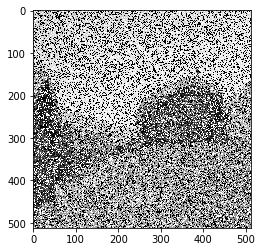

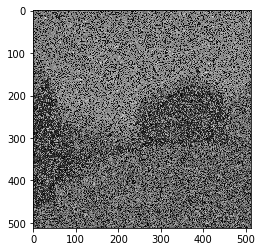

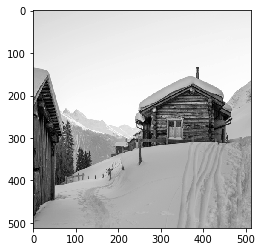

7.874676585197449
8.278084397315979


'\ntotalPSNR = 0\nfor i in range(2800):\n    totalPSNR += PSNR(y_train[i], X_train[i])\n#print(totalPSNR)\nprint(totalPSNR / 2800)\n\ntotalPSNR = 0\nfor i in range(2800):\n    totalPSNR += PSNR(y_train[i], result[i])\n#print(totalPSNR)\nprint(totalPSNR / 2800)\n\ntotalSSIM = 0\nfor i in range(2800):\n    totalSSIM += SSIM(y_train[i], X_train[i], 1.0, multichannel=True)\n#print(totalSSIM)\nprint(totalSSIM / 2800)\n\ntotalSSIM = 0\nfor i in range(2800):\n    totalSSIM += SSIM(y_train[i], result[i], 1.0, multichannel=True)\n#print(totalSSIM)\nprint(totalSSIM / 2800)\n'

In [12]:
X_train = X_train.reshape(-1, 512, 512, 1)
result = model.predict(X_train, batch_size=8)
result = result.reshape(-1, 512, 512)
X_train = X_train.reshape(-1, 512, 512)
y_train = y_train.reshape(-1, 512, 512)
img = X_train[1]
plt.imshow(img, cmap="gray")
plt.show()
# show the image
img = result[1]
plt.imshow(img, cmap="gray")
plt.show()
img = y_train[1]
plt.imshow(img, cmap="gray")
plt.show()
print(PSNR(y_train[1], X_train[1]) )
print(PSNR(y_train[1], result[1]) )
"""
totalPSNR = 0
for i in range(2800):
    totalPSNR += PSNR(y_train[i], X_train[i])
#print(totalPSNR)
print(totalPSNR / 2800)

totalPSNR = 0
for i in range(2800):
    totalPSNR += PSNR(y_train[i], result[i])
#print(totalPSNR)
print(totalPSNR / 2800)

totalSSIM = 0
for i in range(2800):
    totalSSIM += SSIM(y_train[i], X_train[i], 1.0, multichannel=True)
#print(totalSSIM)
print(totalSSIM / 2800)

totalSSIM = 0
for i in range(2800):
    totalSSIM += SSIM(y_train[i], result[i], 1.0, multichannel=True)
#print(totalSSIM)
print(totalSSIM / 2800)
"""